In [2]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

DEFAULT_ROOT = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path.cwd().parents[0]
ROOT = Path(os.environ.get("GENDER_BIAS_ROOT", DEFAULT_ROOT))


def sanitize(name: str) -> str:
    return name.replace("/", "-")


In [1]:
%matplotlib inline


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [ ]:
model_names = [
                'google/gemma-7b-it',
                'meta-llama/Llama-3.1-8B-Instruct', 
                'mistralai/Mistral-7B-Instruct-v0.1', 
                ]

concepts = ["professions", "sports", "months", "colors", "languages", "diseases"]


methods = [
    "base", 
    "sft", 
    "sft_instruction_in_prompt_jailbreak"
]

methods_all = [
    "base",
    "sft", 
    #"sft_instruction_in_prompt_jailbreak"
]

suffix_to_method = {
    "": "Base",
    "_lora_sft": "FT",
    #"_lora_sft_instruction_in_prompt_jailbreak": "SFT + Instruction (Jailbreak)",
}


dico_methods = {
    "base": "Base",
    "sft": "FT",
    "sft_instruction_in_prompt_jailbreak": "FT + Instruction (biais)",
}

ordered_methods = [
    "Base",
    "FT",
    "FT + Instruction (biais)"
]



In [5]:
from pathlib import Path

DEFAULT_ROOT = (
    Path(__file__).resolve().parents[2]
    if "__file__" in globals()
    else Path.cwd().parents[1]      
)
ROOT = Path(os.environ.get("GENDER_BIAS_ROOT", DEFAULT_ROOT))


In [6]:
DEFAULT_ROOT

PosixPath('/home/bouchouchi/Gender_Bias')

In [7]:
PLOTS_BASE = DEFAULT_ROOT / "results" / "plots"
for sub in ["correlation", "ppl", "results_eval", "dot_prod", "generation", "direction_ablation", "probs_next_token"]:
    (PLOTS_BASE / sub).mkdir(parents=True, exist_ok=True)


In [8]:
device = os.environ.get("CUDA_VISIBLE_DEVICES", "CPU")
device = "cuda" if "cuda" in device else "cpu"

## dot prod : plot

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from pathlib import Path

# ROOT si pas déjà défini plus haut
DEFAULT_ROOT = Path.cwd().parents[1]
ROOT = Path(os.environ.get("GENDER_BIAS_ROOT", DEFAULT_ROOT))

similarity_type = "dot_products" #"dot_products"  # "dot_products" ou "cosine_similarities" ou "dot_products_zscore" ou "dot_products_whitened"
score_type = "std_norm_dot"       # "std_norm_dot" ou "std_dot" (std_norm_dot uniquement pour dot_products)

# ---- Contrôle de l'ordre des abscisses ----
fix_concept_order = False          # True => ordre global fixé pour toutes les sous-figures
custom_order = None                # Optionnel : liste personnalisée des professions (utilisée si fix_concept_order=True)
only_latent = True                # True => n'affiche que la barre du score latent (plus petit)

cmap = cm.get_cmap('viridis')

def plot_dot_product_bars(model_name, layers=None, ylim=None):
    for concept in concepts:
        # Définition des couches selon le modèle
        if not layers:
            if model_name == "google/gemma-2-9b-it":
                layers = [5, 10, 15, 20, 25, 30, 35, 40]
            elif model_name == "Qwen/Qwen2.5-7B-Instruct" or model_name == "google/gemma-7b-it":
                layers = [5, 10, 15, 20, 25]
            else:
                layers = [5, 10, 15, 20, 25, 30]

        folder_to_method = {
            f"{model_name}{suffix}": method
            for suffix, method in suffix_to_method.items()
        }

        # --------- Stockage par (layer, method) ---------
        data = {layer: {} for layer in layers}      # means par (layer, method)
        std_data = {layer: {} for layer in layers}  # std par (layer, method)
        order = {layer: {} for layer in layers}     # labels (Concept) par (layer, method)

        vmin_per_layer = {}
        vmax_per_layer = {}

        # Ordre global si demandé
        global_order = custom_order if (fix_concept_order and custom_order is not None) else None

        # --- Lecture des données : mean + std + labels ---
        for layer in layers:
            for folder, method_name in folder_to_method.items():
                file_path = ROOT / "results" / "dot_prod" / folder / (similarity_type if similarity_type != "dot_products_whitened" else "dot_products") / f"{similarity_type}_{concept}_L{layer}.csv"
                if file_path.exists():
                    df = pd.read_csv(file_path)

                    # Labels locaux lus dans le CSV
                    labels_local = df["Concept"].tolist()
                    means_local = df["Mean"].tolist()
                    stds_local = df["Std"].tolist()

                    # Si on veut un ordre global mais qu'on ne l'a pas encore, on le déduit du 1er CSV rencontré
                    if fix_concept_order and global_order is None:
                        global_order = labels_local.copy()

                    # On stocke tel quel (ordre local pour ce CSV)
                    order[layer][method_name] = labels_local
                    data[layer][method_name] = means_local
                    std_data[layer][method_name] = stds_local
                else:
                    print(f"Fichier manquant : {file_path}")
                    order[layer][method_name] = []   # pas de labels pour ce subplot
                    data[layer][method_name] = []    # pas de valeurs
                    std_data[layer][method_name] = []

            # Calcul min/max incluant les barres d’erreur (sur les données disponibles)
            all_bounds = []
            for method_name in folder_to_method.values():
                means = data[layer].get(method_name, [])
                stds = std_data[layer].get(method_name, [])
                for m, s in zip(means, stds):
                    if not np.isnan(m):
                        all_bounds.append(m + s)
                        all_bounds.append(m - s)
            vmin_per_layer[layer] = min(all_bounds) if all_bounds else 0.0
            vmax_per_layer[layer] = max(all_bounds) if all_bounds else 1.0

        # --------------- Figure ---------------
        num_rows = len(layers)
        num_cols = len(folder_to_method)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(3.8 * num_cols, 2.9 * num_rows), squeeze=False) #3.8 x 2.9

        for row_idx, layer in enumerate(layers):
            vmin = vmin_per_layer[layer]
            vmax = vmax_per_layer[layer]
            margin = 0.05 * (vmax - vmin) if vmax > vmin else 1.0
            y_lower = vmin - margin
            y_upper = vmax + margin
            denom = (vmax - vmin) if (vmax > vmin) else 1.0  # évite division par zéro pour les couleurs

            for col_idx, method_name in enumerate(folder_to_method.values()):
                ax = axes[row_idx, col_idx]

                labels_local = order[layer].get(method_name, [])
                means_local = data[layer].get(method_name, [])
                stds_local = std_data[layer].get(method_name, [])

                # --- Choix de l’ordre à tracer ---
                if fix_concept_order and global_order is not None:
                    # On aligne les données locales sur l'ordre global
                    map_vals = {lab: (m, s) for lab, m, s in zip(labels_local, means_local, stds_local)}
                    labels = global_order
                    means = []
                    stds = []
                    for lab in labels:
                        if lab in map_vals:
                            m, s = map_vals[lab]
                        else:
                            m, s = (np.nan, 0.0)  # absent dans ce CSV
                        means.append(m)
                        stds.append(s)
                else:
                    # On garde l'ordre local propre à (layer, method)
                    labels = labels_local
                    means = means_local
                    stds = stds_local

                # Positions numériques robustes
                x = np.arange(len(labels))

                # Couleurs normalisées globalement pour la couche
                normed_colors = [
                    cmap((m - vmin) / denom) if (len(labels) > 0 and not np.isnan(m)) else (0.8, 0.8, 0.8, 1.0)
                    for m in means
                ]

                # Tracé
                ax.bar(
                    x, means,
                    yerr=stds,
                    color=normed_colors,
                    edgecolor='black',
                    capsize=2,
                    linewidth=0.5
                )
                if ylim:
                    ax.set_ylim(ylim[0], ylim[1])
                else:
                    ax.set_ylim(y_lower, y_upper)
                ax.set_xticks(x)
                ax.set_xticklabels(labels, rotation=55, fontsize=7, ha='right')

                if row_idx == 0:
                    ax.set_title(method_name, fontsize=11)
                if col_idx == 0:
                    if only_latent:
                        ax.set_ylabel(r"$\text{s}^l_{\text{latent}}$", fontsize=9)
                        
                    elif len(layers) == 1:
                        ax.set_ylabel("")  

                        ax.text(
                            -0.2, 0.5, f"Layer {layer}",
                            transform=ax.transAxes, rotation=90,
                            va='center', ha='right', fontsize=10
                        )

                        # Ligne 2 : score plus petit en dessous
                        ax.text(
                            -0.12, 0.5, r"$\text{s}^l_{\text{latent}}$",
                            transform=ax.transAxes, rotation=90,
                            va='center', ha='right', fontsize=9
                        )
                    else:
                        ax.set_ylabel(f"Layer {layer}", fontsize=10)
                else:
                    ax.set_yticklabels([])

                ax.tick_params(axis='y', labelsize=7, rotation=0)
                ax.grid(True, axis='y', alpha=0.25, linewidth=0.6)

        # fig.suptitle(f"{similarity_type.replace('_', ' ').title()} pour '{concept}' - {model_name}", fontsize=15)
        # plt.tight_layout(rect=[0, 0, 1, 0.95])
        # plt.tight_layout(rect=[0, 0, 1, 1])
        plt.tight_layout(pad=0.1, rect=[0, 0, 1, 1])


        # --------------- Sauvegarde ---------------
        plots_out = PLOTS_BASE / "dot_prod"
        plots_out.mkdir(parents=True, exist_ok=True)
        tag = "fixed" if fix_concept_order else "free"
        if layers:
            tag_layers = f"_L{'_'.join(map(str, layers))}"
        out_base = plots_out / f"{model_name.split('/')[-1]}_{similarity_type}_{concept}_{tag}{tag_layers if layers else ''}"
        plt.savefig(f"{out_base}.png", dpi=300)
        plt.savefig(f"{out_base}.pdf", dpi=300)

        # Affichage conditionnel (comme avant)
        # if model_name.startswith("meta-llama") and concept == "professions":
        plt.show()
        # else:
            # plt.close(fig)


/tmp/ipykernel_1502821/3779063315.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


In [10]:
# for model_name in model_names:
#     plot_dot_product_bars(model_name)

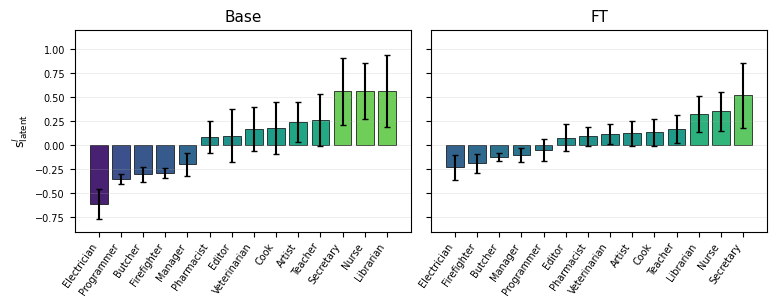

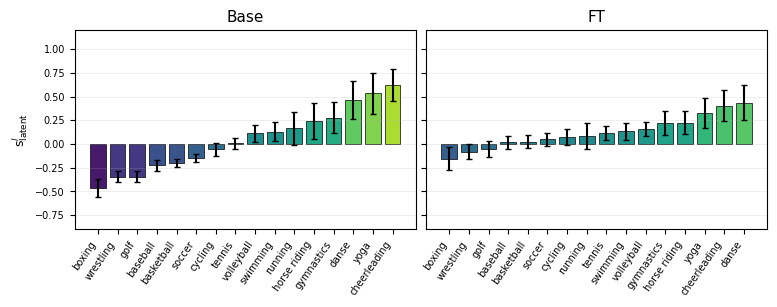

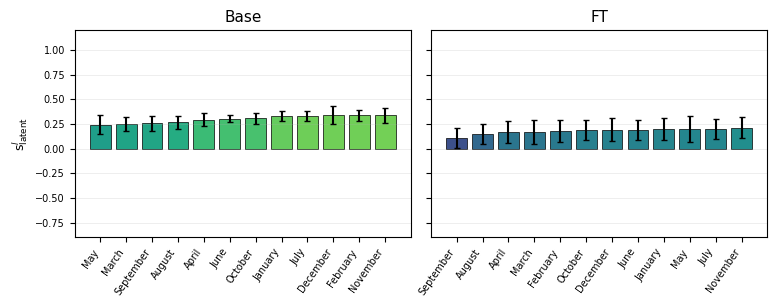

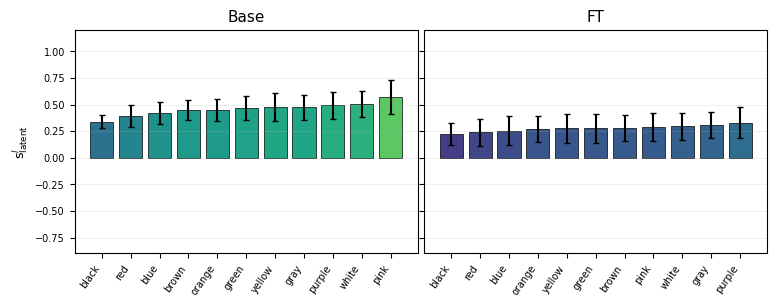

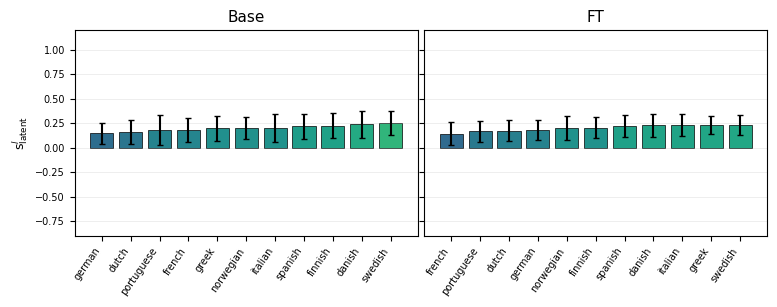

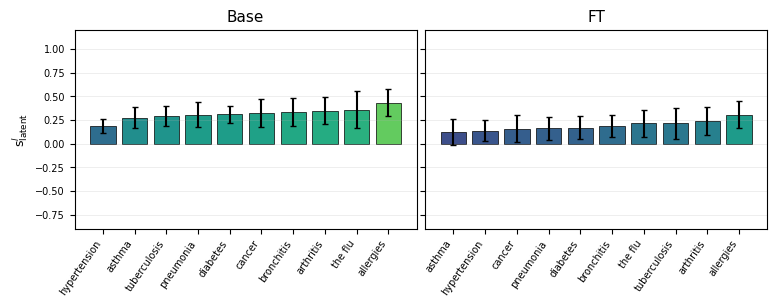

In [11]:
plot_dot_product_bars("meta-llama/Llama-3.1-8B-Instruct", layers = [20], ylim=(-0.9, 1.2))
# plot_dot_product_bars("meta-llama/Llama-3.1-8B-Instruct", layers = [20], ylim=(-0.045, 0.06))


## dot prod : score global

In [ ]:
import os, sys

SRC_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # src/
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

In [ ]:
from models.hf import get_model
from constants import PERSON, CONCEPTS, SCHEMA
from utils.directions import compute_lambdas, compute_gender_direction


In [ ]:
import numpy as np
import torch

def compute_random_dir_layerwise_global_dict(
    model_name: str,
    use_model_ft_sft: bool,
    n_dirs: int = 200,
    base_seed: int = 0,
    normalize_by_norms: bool = True,
    use_cuda: bool = torch.cuda.is_available(),
) -> dict:
    """
    Retourne un dict[layer] -> {mean, p025, p50, p975}
    IC95 strict (2.5% / 97.5%) par couche en agrégeant TOUS les concepts.
    S_l(v) = std_i(mu_l(i)) / E||lambda|| si normalize_by_norms=True.
    """
    layers = list(range(28)) if model_name == "google/gemma-7b-it" else list(range(32))
    device = "cuda" if use_cuda else "cpu"

    print(f"[random-dir GLOBAL] {model_name} | SFT={use_model_ft_sft} | n_dirs={n_dirs} | normalize={normalize_by_norms}")
    model_hf, tokenizer = get_model(
        model_name,
        use_model_ft_dpo=False,
        use_model_ft_sft=use_model_ft_sft
    )
    model_hf.eval()

    results = {}

    for layer in layers:
        # Récup activations neutres pour tous les concepts (fusion catégories)
        items_to_tensors = {}
        all_neutral = []

        for category in concepts:
            for item in CONCEPTS[category]:
                sentences = [f"{person}{SCHEMA[category]}{item.lower()}." for person in PERSON["neutral"]]
                acts = [
                    compute_lambdas(
                        s, model_hf, tokenizer, layer,
                        model_name, ft=use_model_ft_sft,
                        system_prompt=None,
                        instruction_in_prompt=False
                    )
                    for s in sentences
                ]
                tensors = [a[0].detach().to(device).float() for a in acts]
                if tensors:
                    items_to_tensors[item] = tensors
                    all_neutral.extend(tensors)

        if not all_neutral or not items_to_tensors:
            results[layer] = {"mean": np.nan, "p025": np.nan, "p50": np.nan, "p975": np.nan}
            continue

        dim = all_neutral[0].numel()

        if normalize_by_norms:
            denom = float(torch.mean(torch.stack([t.norm() for t in all_neutral])).cpu())
            if denom <= 0:
                denom = np.nan
        else:
            denom = 1.0

        seed = np.abs(hash((model_name, int(use_model_ft_sft), layer, "GLOBAL", base_seed))) % (2**32)
        rng = np.random.default_rng(seed)

        vals = []
        for _ in range(n_dirs):
            v = rng.normal(size=(dim,)).astype(np.float32)
            n = np.linalg.norm(v)
            if n == 0:
                v[0] = 1.0; n = 1.0
            v_t = torch.from_numpy(v / n).to(device)

            mu_vals = []
            for _, X_list in items_to_tensors.items():
                X = torch.stack(X_list, dim=0)   # (N_i, dim)
                mu = (X @ v_t).mean()
                mu_vals.append(float(mu.cpu()))

            if mu_vals:
                numer = float(np.std(mu_vals, ddof=0))
                score = numer / denom if (normalize_by_norms and denom and not np.isnan(denom)) else numer
                vals.append(score)

        arr = np.asarray(vals, dtype=float)
        if arr.size == 0 or np.all(np.isnan(arr)):
            results[layer] = {"mean": np.nan, "p025": np.nan, "p50": np.nan, "p975": np.nan}
        else:
            results[layer] = {
                "mean": float(np.nanmean(arr)),
                "p025": float(np.nanpercentile(arr, 2.5)),
                "p50":  float(np.nanpercentile(arr, 50.0)),
                "p975": float(np.nanpercentile(arr, 97.5)),
            }

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return results


# ========= Lancement pour tous les modèles : format demandé =========
import json        
out_dir = ROOT / "results" / "dot_prod" / "random_dir"
out_dir.mkdir(parents=True, exist_ok=True)

# dico_results_random_dir     = {model: {} for model in model_names}  # Base
# dico_results_random_dir_sft = {model: {} for model in model_names}  # SFT

# for model in model_names:
#     dico_results_random_dir[model]     = compute_random_dir_layerwise_global_dict(
#         model_name=model, use_model_ft_sft=False, n_dirs=200, base_seed=42, normalize_by_norms=True
#     )
#     dico_results_random_dir_sft[model] = compute_random_dir_layerwise_global_dict(
#         model_name=model, use_model_ft_sft=True,  n_dirs=200, base_seed=42, normalize_by_norms=True
#     )

# with open(out_dir / "random_dir_GLOBAL.json", "w") as f:
#     json.dump({
#         "base": dico_results_random_dir,
#         "sft":  dico_results_random_dir_sft
#     }, f, indent=2)


In [17]:
import numpy as np
import torch
import json
from pathlib import Path

def compute_random_dir_layerwise_global_dict(
    model_name: str,
    use_model_ft_sft: bool,
    n_dirs: int = 200,
    base_seed: int = 0,
    normalize_by_norms: bool = True,
    use_cuda: bool = torch.cuda.is_available(),
):
    """
    Retourne un tuple:
      - results_global[layer] -> {mean, p025, p50, p975}  (baseline globale tous concepts)
      - results_concept[concept][layer] -> {mean, p025, p50, p975}  (baseline par concept)
    """
    layers = list(range(28)) if model_name == "google/gemma-7b-it" else list(range(32))
    device = "cuda" if use_cuda else "cpu"

    print(f"[random-dir GLOBAL+CONCEPT] {model_name} | SFT={use_model_ft_sft} | n_dirs={n_dirs} | normalize={normalize_by_norms}")
    model_hf, tokenizer = get_model(
        model_name,
        use_model_ft_dpo=False,
        use_model_ft_sft=use_model_ft_sft
    )
    model_hf.eval()

    results_global  = {}   # baseline globale
    results_concept = {}   # baseline par concept

    for layer in layers:
        # Accumulateurs "global"
        items_to_tensors_global = {}
        all_neutral_global = []

        # ---- boucle concepts : calcule baseline par concept ET nourrit le global ----
        for category in concepts:
            items_to_tensors_C = {}
            all_neutral_C = []

            for item in CONCEPTS[category]:
                sentences = [f"{person}{SCHEMA[category]}{item.lower()}." for person in PERSON["neutral"]]
                acts = [
                    compute_lambdas(
                        s, model_hf, tokenizer, layer,
                        model_name, ft=use_model_ft_sft,
                        system_prompt=None,
                        instruction_in_prompt=False
                    )
                    for s in sentences
                ]
                tensors = [a[0].detach().to(device).float() for a in acts if a is not None]
                if not tensors:
                    continue

                # alimente le global
                items_to_tensors_global[item] = tensors
                all_neutral_global.extend(tensors)

                # alimente le concept courant
                items_to_tensors_C[item] = tensors
                all_neutral_C.extend(tensors)

            # baseline pour ce concept (même couche)
            if category not in results_concept:
                results_concept[category] = {}

            if not all_neutral_C:
                results_concept[category][layer] = {"mean": np.nan, "p025": np.nan, "p50": np.nan, "p975": np.nan}
            else:
                dim = all_neutral_C[0].numel()
                # dénominateur aligné avec l'observé (par concept)
                if normalize_by_norms:
                    denom = float(torch.mean(torch.stack([t.norm() for t in all_neutral_C])).cpu())
                    if denom <= 0: denom = np.nan
                else:
                    denom = 1.0

                # seed reproductible par (modèle, SFT, couche, concept)
                seed = np.abs(hash((model_name, int(use_model_ft_sft), layer, category, base_seed))) % (2**32)
                rng = np.random.default_rng(seed)

                vals = []
                for _ in range(n_dirs):
                    v = rng.normal(size=(dim,)).astype(np.float32)
                    n = np.linalg.norm(v)
                    if n == 0:
                        v[0] = 1.0; n = 1.0
                    v_t = torch.from_numpy(v / n).to(device)

                    mu_vals = []
                    for _, X_list in items_to_tensors_C.items():
                        X = torch.stack(X_list, dim=0)
                        mu = (X @ v_t).mean()
                        mu_vals.append(float(mu.cpu()))

                    if mu_vals:
                        numer = float(np.std(mu_vals, ddof=0))
                        score = numer / denom if (normalize_by_norms and denom and not np.isnan(denom)) else numer
                        vals.append(score)

                arr = np.asarray(vals, dtype=float)
                if arr.size == 0 or np.all(np.isnan(arr)):
                    results_concept[category][layer] = {"mean": np.nan, "p025": np.nan, "p50": np.nan, "p975": np.nan}
                else:
                    results_concept[category][layer] = {
                        "mean": float(np.nanmean(arr)),
                        "p025": float(np.nanpercentile(arr, 2.5)),
                        "p50":  float(np.nanpercentile(arr, 50.0)),
                        "p975": float(np.nanpercentile(arr, 97.5)),
                    }

        # ---- baseline globale (même recette, mais tous concepts confondus) ----
        if not all_neutral_global or not items_to_tensors_global:
            results_global[layer] = {"mean": np.nan, "p025": np.nan, "p50": np.nan, "p975": np.nan}
        else:
            dim = all_neutral_global[0].numel()
            if normalize_by_norms:
                denom_g = float(torch.mean(torch.stack([t.norm() for t in all_neutral_global])).cpu())
                if denom_g <= 0: denom_g = np.nan
            else:
                denom_g = 1.0

            seed = np.abs(hash((model_name, int(use_model_ft_sft), layer, "GLOBAL", base_seed))) % (2**32)
            rng = np.random.default_rng(seed)

            vals = []
            for _ in range(n_dirs):
                v = rng.normal(size=(dim,)).astype(np.float32)
                n = np.linalg.norm(v)
                if n == 0:
                    v[0] = 1.0; n = 1.0
                v_t = torch.from_numpy(v / n).to(device)

                mu_vals = []
                for _, X_list in items_to_tensors_global.items():
                    X = torch.stack(X_list, dim=0)
                    mu = (X @ v_t).mean()
                    mu_vals.append(float(mu.cpu()))

                if mu_vals:
                    numer = float(np.std(mu_vals, ddof=0))
                    score = numer / denom_g if (normalize_by_norms and denom_g and not np.isnan(denom_g)) else numer
                    vals.append(score)

            arr = np.asarray(vals, dtype=float)
            if arr.size == 0 or np.all(np.isnan(arr)):
                results_global[layer] = {"mean": np.nan, "p025": np.nan, "p50": np.nan, "p975": np.nan}
            else:
                results_global[layer] = {
                    "mean": float(np.nanmean(arr)),
                    "p025": float(np.nanpercentile(arr, 2.5)),
                    "p50":  float(np.nanpercentile(arr, 50.0)),
                    "p975": float(np.nanpercentile(arr, 97.5)),
                }

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return results_global, results_concept


out_dir = ROOT / "results" / "dot_prod" / "random_dir2"
out_dir.mkdir(parents=True, exist_ok=True)

# dico_all = {"base": {}, "sft": {}}

# for model in model_names:
#     # BASE
#     glob_base, concept_base = compute_random_dir_layerwise_global_dict(
#         model_name=model, use_model_ft_sft=False, n_dirs=200, base_seed=42, normalize_by_norms=True
#     )
#     # SFT
#     glob_sft, concept_sft = compute_random_dir_layerwise_global_dict(
#         model_name=model, use_model_ft_sft=True, n_dirs=200, base_seed=42, normalize_by_norms=True
#     )

#     dico_all["base"][model] = {"global": glob_base, "concept": concept_base}
#     dico_all["sft"][model]  = {"global": glob_sft,  "concept": concept_sft}

# with open(out_dir / "random_dir_GLOBAL.json", "w") as f:
#     json.dump(dico_all, f, indent=2)


In [18]:
out_dir

PosixPath('/home/bouchouchi/Gender_Bias/results/dot_prod/random_dir2')

In [19]:
# load  dico_results_random_dir  et dico_results_random_dir_sft  depuis random_dir_GLOBAL.json
with open(out_dir / "random_dir_GLOBAL.json", "r") as f:
    data = json.load(f)
    dico_results_random_dir = data["base"]
    dico_results_random_dir_sft = data["sft"]

In [20]:
dico_results_random_dir_sft

{'google/gemma-7b-it': {'global': {'0': {'mean': 0.001685850407715916,
    'p025': 0.0010378625461112995,
    'p50': 0.001602636013030225,
    'p975': 0.0028649840466751873},
   '1': {'mean': 0.00292982047615633,
    'p025': 0.0018935052942645526,
    'p50': 0.002767736262631956,
    'p975': 0.004633830933229277},
   '2': {'mean': 0.003722115770887171,
    'p025': 0.0023813018303353744,
    'p50': 0.00372690474672927,
    'p975': 0.00542071019204984},
   '3': {'mean': 0.007081622030556072,
    'p025': 0.00420691787103431,
    'p50': 0.006811533745386145,
    'p975': 0.011426107893306413},
   '4': {'mean': 0.009105360800333662,
    'p025': 0.004895195757876796,
    'p50': 0.008810731103874545,
    'p975': 0.01542912007759029},
   '5': {'mean': 0.008522049791973166,
    'p025': 0.004919428056568194,
    'p50': 0.008224640430851398,
    'p975': 0.01347540175070717},
   '6': {'mean': 0.010233710420341739,
    'p025': 0.005993914216133979,
    'p50': 0.00960657608882326,
    'p975': 0.01757

In [21]:
dico_results_random_dir_sft['meta-llama/Llama-3.1-8B-Instruct']["concept"]

{'professions': {'0': {'mean': 0.0016796041259421574,
   'p025': 0.0010128675147668068,
   'p50': 0.0016365672256061384,
   'p975': 0.002451314833496231},
  '1': {'mean': 0.0038408528543067704,
   'p025': 0.0024707687212425886,
   'p50': 0.003703305945101675,
   'p975': 0.005764615296223468},
  '2': {'mean': 0.0029873243453283124,
   'p025': 0.001800932516114626,
   'p50': 0.003006196182915904,
   'p975': 0.0041162055261498385},
  '3': {'mean': 0.003434222408910694,
   'p025': 0.0019865308736244937,
   'p50': 0.0034387637044627547,
   'p975': 0.0047851565417345076},
  '4': {'mean': 0.004014584065216754,
   'p025': 0.0025984276110709976,
   'p50': 0.003937159410429171,
   'p975': 0.005891958292405411},
  '5': {'mean': 0.0034932590706422623,
   'p025': 0.00200844083350032,
   'p50': 0.0034708645593027393,
   'p975': 0.005278574556366583},
  '6': {'mean': 0.0038091454121268365,
   'p025': 0.002389452098507546,
   'p50': 0.0036932298607974803,
   'p975': 0.005956128040196708},
  '7': {'mea

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # proxy pour la légende "random"

def plot_dot_product_lineplots(similarity_type="dot_products", score_type="std_norm_dot", SHOW_RANDOM=True, plot_legend=True, use_global=True): 
    if similarity_type != "dot_products" and score_type == "std_norm_dot":
        raise ValueError("std_norm_dot n'est disponible que pour similarity_type='dot_products'.")

    def is_sft_method(method_name: str) -> bool:
        """Détecte si le panneau correspond à SFT (adapte selon tes libellés)."""
        name = method_name.strip().lower()
        return ("sft" in name) or ("fine-tune" in name) or ("fine tuning" in name) or ("ft" in name)

    for model_name in model_names:

        # Associe chaque dossier (run) à un libellé méthode
        folder_to_method = {
            f"{model_name}{suffix}": method
            for suffix, method in suffix_to_method.items()
        }

        # Chargement des CSV
        all_data = {}
        for folder, method_name in folder_to_method.items():
            file_path = ROOT / "results" / "dot_prod" / folder / f"bias_scores_{similarity_type}.csv"
            if not os.path.exists(file_path):
                print(f"Fichier manquant : {file_path}")
                continue

            df = pd.read_csv(file_path)
            if "concept" not in df.columns or score_type not in df.columns:
                print(f"Colonnes manquantes dans {file_path} (attendues: 'concept' et '{score_type}')")
                continue

            df = df[df["concept"].isin(concepts)]
            if df.empty:
                continue

            all_data[method_name] = df

        if not all_data:
            print(f"Aucune donnée à tracer pour {model_name}")
            continue

        num_methods = len(all_data)
        fig, axes = plt.subplots(1, num_methods, figsize=(8 * num_methods, 4), sharey=True)
        if num_methods == 1:
            axes = [axes]

        # Couleurs par concept
        colors = {
            "professions": "#1f77b4",
            "colors": "#ff7f0e",
            "months": "#2ca02c",
            "sports": "#d62728",
            "languages": "#9467bd",
            "diseases": "#e377c2",
        }

        # Légende globale (une seule fois)
        legend_handles, legend_labels = [], []
        seen_labels = set()

        # Bornes Y **globales** (courbes + bande random)
        global_y_min = float("inf")
        global_y_max = float("-inf")

        # 1) Tracé de chaque panneau
        for ax, (method_name, df) in zip(axes, all_data.items()):

            # --- Courbes observées par concept ---
            for concept in concepts:
                df_c = df[df["concept"] == concept]
                if df_c.empty:
                    continue
                h, = ax.plot(
                    df_c["layer"], df_c[score_type],
                    marker="o", label=concept,
                    color=colors.get(concept, None),
                    linewidth=1, markersize=3, zorder=3
                )
                # Légende (une entrée par concept)
                if concept not in seen_labels:
                    legend_handles.append(h)
                    legend_labels.append(concept)
                    seen_labels.add(concept)

                # maj bornes globales avec les courbes
                global_y_min = min(global_y_min, df_c[score_type].min())
                global_y_max = max(global_y_max, df_c[score_type].max())

            # --- Bande random *unique* (IC95 global all concepts, layerwise) ---
            if SHOW_RANDOM:
                # Sélectionne le bon dico (base vs sft)
                rand_all = dico_results_random_dir_sft if is_sft_method(method_name) else dico_results_random_dir

                if model_name in rand_all and rand_all[model_name]:
                    if use_global:
                        # ===== Bande GLOBALE (tous concepts confondus) =====
                        layer_keys = rand_all[model_name]['global'].keys()          # clés JSON -> str
                        layers_sorted = sorted(int(k) for k in layer_keys)          # -> int pour trier
                        source = rand_all[model_name]['global']

                        lx, lower, upper = [], [], []
                        for l in layers_sorted:
                            stats = source[str(l)]                                  # accès JSON -> str
                            lo, hi = stats.get("p025", np.nan), stats.get("p975", np.nan)
                            if not (np.isnan(lo) or np.isnan(hi)):
                                lx.append(l); lower.append(lo); upper.append(hi)

                        if lx:
                            ax.fill_between(lx, lower, upper,
                                            color="#aaaaaa", alpha=0.25,
                                            label="Aléatoire (global)", zorder=1)
                            global_y_min = min(global_y_min, np.nanmin(lower))
                            global_y_max = max(global_y_max, np.nanmax(upper))

                            if "Aléatoire (global)" not in seen_labels:
                                legend_handles.append(mpatches.Patch(facecolor="#aaaaaa", alpha=0.25, label="Aléatoire (global)"))
                                legend_labels.append("Aléatoire (global)")
                                seen_labels.add("Aléatoire (global)")

                    else:
                        # ===== Bandes PAR CONCEPT =====
                        if "concept" not in rand_all[model_name]:
                            print(f"[WARN] Pas de baseline par concept pour {model_name}")
                        else:
                            for concept in concepts:
                                concept_src = rand_all[model_name]["concept"].get(concept, {})
                                if not concept_src:
                                    continue

                                layer_keys = concept_src.keys()
                                layers_sorted = sorted(int(k) for k in layer_keys)

                                lx, lower, upper = [], [], []
                                for l in layers_sorted:
                                    stats = concept_src[str(l)]
                                    lo, hi = stats.get("p025", np.nan), stats.get("p975", np.nan)
                                    if not (np.isnan(lo) or np.isnan(hi)):
                                        lx.append(l); lower.append(lo); upper.append(hi)

                                if lx:
                                    ax.fill_between(lx, lower, upper,
                                                    color=colors.get(concept, None), alpha=0.12,
                                                    zorder=1)
                                    global_y_min = min(global_y_min, np.nanmin(lower))
                                    global_y_max = max(global_y_max, np.nanmax(upper))

                                lbl = f"Aléatoire — {concept}"
                                if lbl not in seen_labels:
                                    patch = mpatches.Patch(
                                        facecolor=colors.get(concept, None),
                                        alpha=0.32,
                                        label=lbl
                                    )
                                    legend_handles.append(patch)
                                    legend_labels.append(lbl)
                                    seen_labels.add(lbl)
                                    
                    

            # Finition panneau (sauf ylim qui sera globale)
            ax.set_title(method_name, fontsize=11)
            ax.set_xlabel("Layer")
            ax.grid(True, zorder=0)
            ax.tick_params(axis='y', labelsize=9)
            if ax == axes[0]:
                ax.set_ylabel(r"$\text{Score}^l_{\text{latent}}$")


        # 2) Appliquer des **ylim globales** à tous les axes (cohérent avec sharey=True)
        if np.isfinite(global_y_min) and np.isfinite(global_y_max):
            margin = 0.05 * (global_y_max - global_y_min) if (global_y_max > global_y_min) else 0.1
            y0, y1 = global_y_min - margin, global_y_max + margin
            for ax in axes:
                ax.set_ylim(y0, y1)

        # 3) Légende unique à droite (dédupliquée)
        if plot_legend :
            fig.legend(
                legend_handles, legend_labels,
                title="Concepts",
                loc="center left", bbox_to_anchor=(0.92, 0.5), fontsize=9
            )

        # plt.suptitle(f"{score_type} par couche — {similarity_type.replace('_', ' ')} - {model_name}", fontsize=14)
        fig.subplots_adjust(wspace=0.1)
        plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite

        # Sauvegarde
        plots_out = PLOTS_BASE / "dot_prod"
        plots_out.mkdir(parents=True, exist_ok=True)
        out_base = plots_out / f"{model_name.split('/')[-1]}_{score_type}_by_layer_{similarity_type}{'_IC95' if SHOW_RANDOM else ''}{'_no_legend' if not plot_legend else ''}"
        plt.savefig(f"{out_base}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{out_base}.pdf", dpi=300, bbox_inches="tight")
        plt.show()


In [23]:
# for plot_legend in [True, False]:
#     plot_dot_product_lineplots(similarity_type="cosine_similarities", score_type="std_dot", SHOW_RANDOM=True, plot_legend=plot_legend, use_global=False)
#     # plot_dot_product_lineplots(similarity_type="cosine_similarities", score_type="std_dot", SHOW_RANDOM=False, plot_legend=plot_legend)

/tmp/ipykernel_1502821/3879144092.py:191: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite


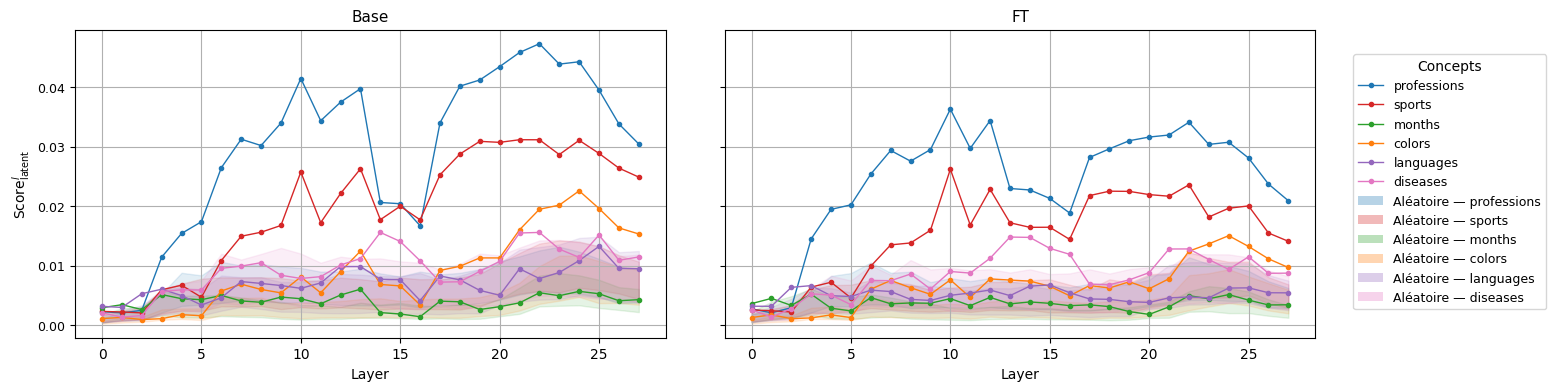

/tmp/ipykernel_1502821/3879144092.py:191: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite


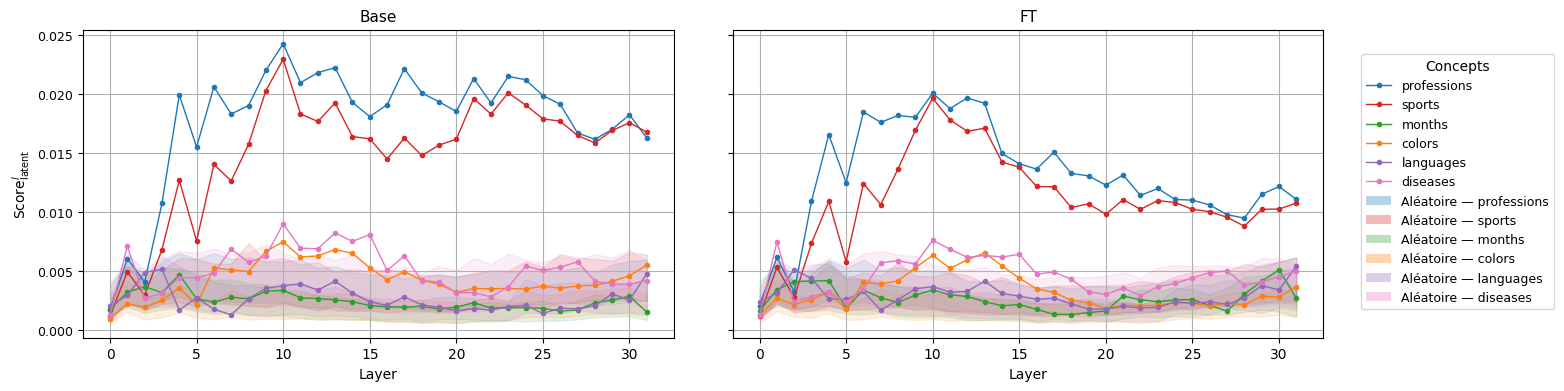

/tmp/ipykernel_1502821/3879144092.py:191: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite


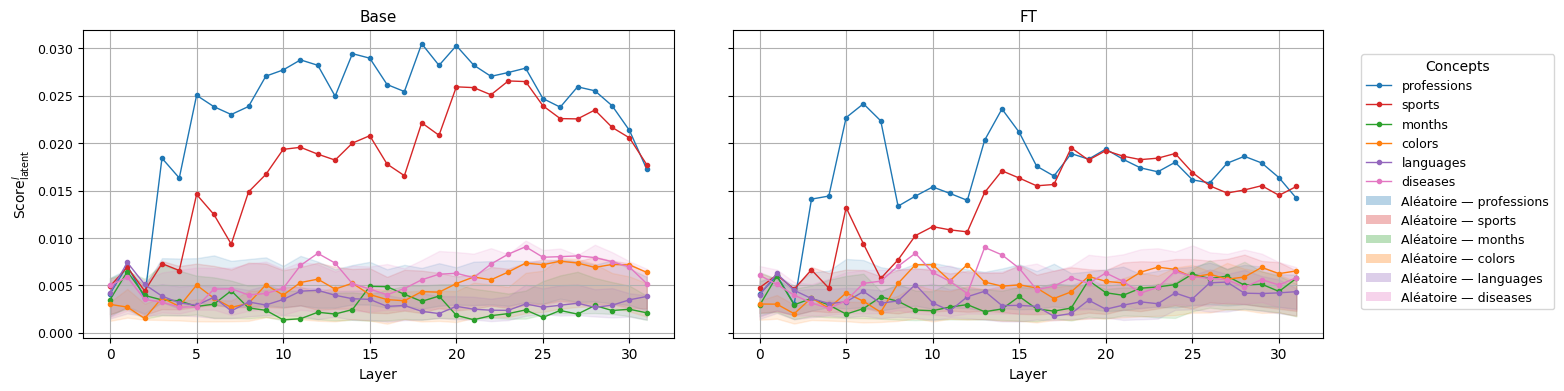

/tmp/ipykernel_1502821/3879144092.py:191: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite


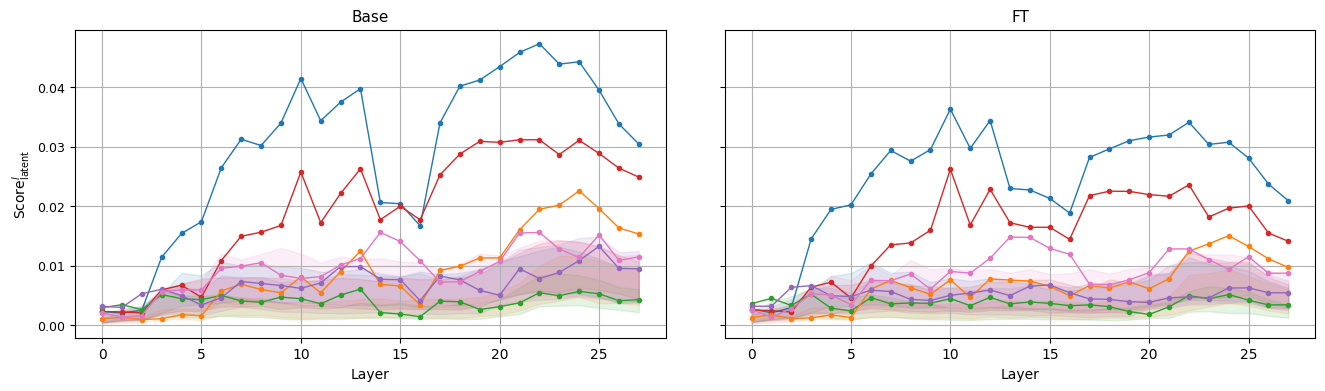

/tmp/ipykernel_1502821/3879144092.py:191: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite


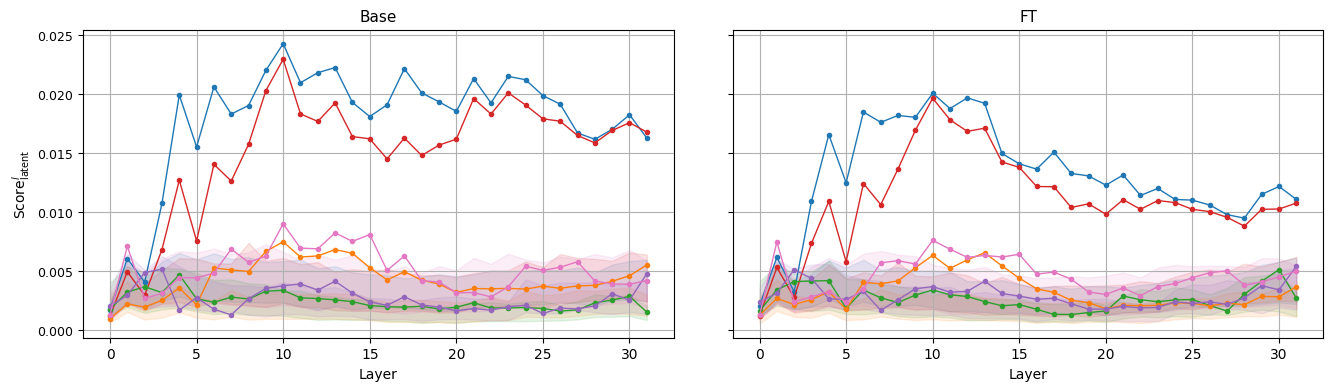

/tmp/ipykernel_1502821/3879144092.py:191: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.2, 0.1])  # espace pour la légende à droite


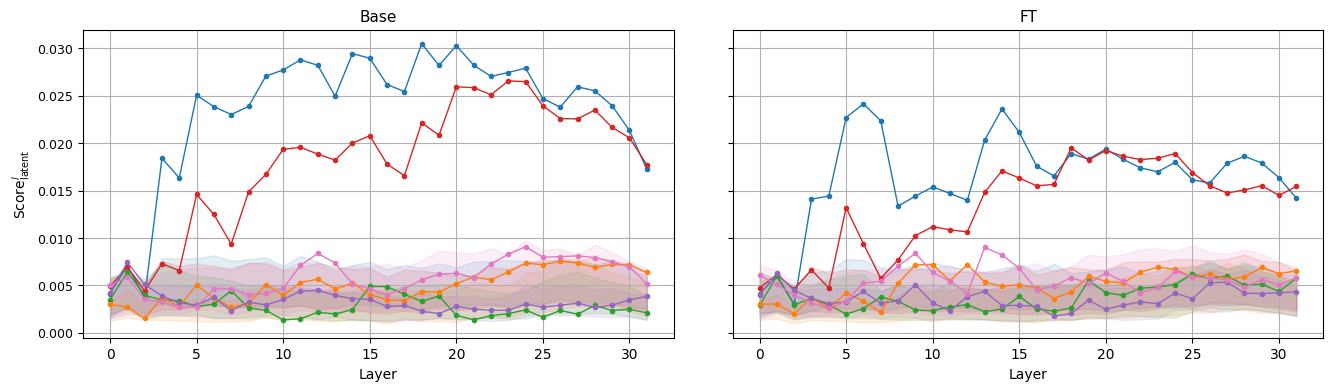

In [24]:
for plot_legend in [True, False]:
    plot_dot_product_lineplots(similarity_type="dot_products", score_type="std_norm_dot", SHOW_RANDOM=True, plot_legend=plot_legend, use_global=False)
    # plot_dot_product_lineplots(similarity_type="dot_products", score_type="std_norm_dot", SHOW_RANDOM=False, plot_legend=plot_legend)

In [43]:
df

,mean_abs_dot,std_dot,std_norm_dot,layer,concept
0,0.045683,0.003974,NaN,0,professions
1,0.049516,0.003041,NaN,0,months
2,0.045410,0.003018,NaN,0,colors
3,0.049357,0.003834,NaN,0,languages
4,0.047702,0.005227,NaN,0,sports
...,...,...,...,...,...
181,0.044851,0.009994,NaN,31,months
182,0.047727,0.006664,NaN,31,colors
183,0.032633,0.003359,NaN,31,languages
184,0.048589,0.017515,NaN,31,sports


## generation : plot all

In [37]:
import numpy as np

model_name = model_names[2]  
print(model_name)
concept = "sports"

similarity_type = "dot_products"  # "dot_products" ou "cosine_similarities" ou "dot_products_zscore"
score_type = "std_norm_dot"       # "std_norm_dot" ou "std_dot

def get_folder(model_name, method):
    suffix = ""
    if method == "sft":
        suffix = "_lora_sft"
    if method.startswith("instruction_"):
        suffix += f"_{method}"
    return ROOT / "results" / "generation" / f"{model_name}{suffix}"

folder = get_folder(model_name, "base")
pred_csv_path = folder / f"{concept}_llama70b_predictions.csv"
df = pd.read_csv(pred_csv_path)
grouped = df.groupby("concept")["predicted_gender"].value_counts().unstack()
# si nan alors 0
grouped = grouped.fillna(0)
grouped["score"] = (grouped["F"] - grouped["M"]) / (grouped["F"] + grouped["M"] + grouped["neutral"])
grouped = grouped.sort_values("score", ascending=False)
grouped

mistralai/Mistral-7B-Instruct-v0.1


predicted_gender,F,M,neutral,score
concept,,,,
cheerleading,25.0,5.0,30.0,0.333333
gymnastics,16.0,6.0,38.0,0.166667
horse riding,13.0,6.0,41.0,0.116667
yoga,10.0,6.0,44.0,0.066667
danse,14.0,17.0,29.0,-0.050000
baseball,2.0,17.0,41.0,-0.250000
running,8.0,25.0,27.0,-0.283333
swimming,5.0,23.0,32.0,-0.300000
volleyball,3.0,23.0,34.0,-0.333333


In [41]:
def plot_generation(model_name, concept, plot_legend=True):
    list_methods = [m for m in methods if m in dico_methods]

    def get_folder(model_name, method):
        suffix = ""
        if method.startswith("sft"):
            if method.startswith("sft_instruction"):
                suffix = f"_lora_{method}" 
            else:
                suffix = "_lora_sft"                
        if method.startswith("instruction_") :
            suffix += f"_{method}"
        return ROOT / "results" / "generation" / f"{model_name}{suffix}"

    all_grouped = {}
    profession_order = None

    for method in list_methods:
        folder = get_folder(model_name, method)
        pred_csv_path = folder / f"{concept}_llama70b_predictions.csv"

        if not pred_csv_path.exists():
            print(f"Manquant : {pred_csv_path}")
            continue

        df = pd.read_csv(pred_csv_path)
        grouped = df.groupby("concept")["predicted_gender"].value_counts().unstack()

        # Forcer la présence de F, neutral, M
        for col in ["F", "neutral", "M"]:
            if col not in grouped.columns:
                grouped[col] = 0
        grouped = grouped[["F", "neutral", "M"]].fillna(0)

        if fix_concept_order:
            if custom_order is not None:
                grouped = grouped.reindex(custom_order)
            elif profession_order is not None:
                grouped = grouped.reindex(profession_order)
            else:
                grouped = grouped.sort_index()
        else:
            grouped = grouped.sort_values(by=["F", "M"], ascending=[True, False])

        if profession_order is None:
            profession_order = grouped.index.tolist()

        all_grouped[method] = grouped

    # Vérification qu'on a des données à afficher
    # if not all_grouped:
    #     print(f"Aucune donnée disponible pour {model_name} - {concept}")
    #     continue

    # Figure
    num_methods = len(all_grouped)
    fig, axes = plt.subplots(1, num_methods, figsize=(4.5 * num_methods, 2), sharey=True)

    if num_methods == 1:
        axes = [axes]

    for ax, method in zip(axes, all_grouped.keys()):
        grouped = all_grouped[method]
        grouped.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=["#377eb8", "#ff7f00", "#4daf4a"],
            legend=False
        )
        ax.set_title(dico_methods[method], fontsize=12)
        # ax.set_xticks(range(len(profession_order)))
        ax.set_xlabel("")
        ax.set_xticklabels(profession_order, rotation=75, fontsize=7)
        if ax == axes[0]:
            ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
            ax.set_ylabel("Nombre de textes", fontsize=10)
        # else:
        #     ax.yaxis.set_ticklabels([])
            
    handles, labels = axes[0].get_legend_handles_labels()

    if plot_legend :
        fig.legend(handles, labels, loc='upper right', ncol=3, title="Genre")

    #plt.suptitle(f"Distribution des genres générés par {concept} — {model_name} ", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.88], w_pad=2)

    # Sauvegarde
    plots_out = PLOTS_BASE / "generation"
    plots_out.mkdir(parents=True, exist_ok=True)
    out_base = plots_out / f"{model_name.split('/')[-1]}_stacked_barplot_comparatif_{concept}{'_no_legend' if not plot_legend else ''}"
    plt.savefig(f"{out_base}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{out_base}.pdf", dpi=300, bbox_inches='tight')
    plt.show()


In [51]:
def plot_generation(model_name, concept, plot_legend=True):
    import numpy as np
    
    list_methods = [m for m in methods if m in dico_methods]

    def get_folder(model_name, method):
        suffix = ""
        if method.startswith("sft"):
            if method.startswith("sft_instruction"):
                suffix = f"_lora_{method}" 
            else:
                suffix = "_lora_sft"                
        if method.startswith("instruction_") :
            suffix += f"_{method}"
        return ROOT / "results" / "generation" / f"{model_name}{suffix}"

    all_grouped = {}
    profession_order = None

    for method in list_methods:
        folder = get_folder(model_name, method)
        pred_csv_path = folder / f"{concept}_llama70b_predictions.csv"

        if not pred_csv_path.exists():
            print(f"Manquant : {pred_csv_path}")
            continue

        df = pd.read_csv(pred_csv_path)
        grouped = df.groupby("concept")["predicted_gender"].value_counts().unstack()

        # Forcer la présence de F, neutral, M
        for col in ["F", "neutral", "M"]:
            if col not in grouped.columns:
                grouped[col] = 0
        grouped = grouped[["F", "neutral", "M"]].fillna(0)

        if fix_concept_order:
            if custom_order is not None:
                grouped = grouped.reindex(custom_order)
            elif profession_order is not None:
                grouped = grouped.reindex(profession_order)
            else:
                grouped = grouped.sort_index()
        else:
            grouped = grouped.sort_values(by=["F", "M"], ascending=[True, False])

        if profession_order is None:
            profession_order = grouped.index.tolist()

        all_grouped[method] = grouped

    # Vérification qu'on a des données à afficher
    if not all_grouped:
        print(f"Aucune donnée disponible pour {model_name} - {concept}")
        return

    # Calculer la valeur maximale globale pour l'offset vertical
    global_top = 0
    for method in all_grouped.keys():
        grouped = all_grouped[method]
        totals = grouped[["F", "neutral", "M"]].sum(axis=1)
        method_max = totals.max()
        if method_max > global_top:
            global_top = method_max
            
    # Figure
    num_methods = len(all_grouped)
    fig, axes = plt.subplots(1, num_methods, figsize=(4.5 * num_methods, 4), sharey=True) #    fig, axes = plt.subplots(1, num_methods, figsize=(4.5 * num_methods, 2), sharey=True)


    if num_methods == 1:
        axes = [axes]

    for ax, method in zip(axes, all_grouped.keys()):
        grouped = all_grouped[method]
        grouped.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=["#377eb8", "#ff7f00", "#4daf4a"],
            legend=False
        )
        ax.set_title(dico_methods[method], fontsize=12)
        ax.set_xlabel("")
        
        # --- Scores ---
        totals = grouped[["F", "neutral", "M"]].sum(axis=1)
        denom = totals.replace(0, np.nan)
        scores = (grouped["F"] - grouped["M"]) / denom

        x = np.arange(len(grouped.index))
        y_tops = totals.values 

        # Offset vertical léger (proportionnel au max global)
        v_offset = 0.03 * global_top if global_top > 0 else 1

        # --- Étiquettes en quinconce + petite police ---
        for i, (xi, yi, s) in enumerate(zip(x, y_tops, scores.values)):
            if not np.isnan(s):
                # petit jitter horizontal alterné pour éviter les collisions visuelles
                h_jitter = (-0.15 if (i % 2 == 0) else 0.15)
                h_jitter = 0
                ax.text(
                    xi + h_jitter +0.02,          # décalage ±
                    yi + v_offset,          # au-dessus de la barre
                    f"{s:.2f}",
                    ha='center', va='bottom',
                    fontsize=7, fontweight='bold',
                    clip_on=False, zorder=5,
                    rotation=90
                )

        ax.set_xticklabels(profession_order, rotation=55, fontsize=8, ha='right')
        if ax == axes[0]:
            ax.yaxis.set_major_locator(mticker.MultipleLocator(20))
            ax.set_ylabel("Nombre de textes", fontsize=10)
        ax.margins(y=0.2)
            
    handles, labels = axes[0].get_legend_handles_labels()

    if plot_legend :
        fig.legend(handles, labels, loc='upper right', ncol=3, title="Genre")

    #plt.suptitle(f"Distribution des genres générés par {concept} — {model_name} ", fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.88], w_pad=2)

    # Sauvegarde
    plots_out = PLOTS_BASE / "generation"
    plots_out.mkdir(parents=True, exist_ok=True)
    out_base = plots_out / f"{model_name.split('/')[-1]}_stacked_barplot_comparatif_{concept}{'_no_legend' if not plot_legend else ''}"
    plt.savefig(f"{out_base}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{out_base}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

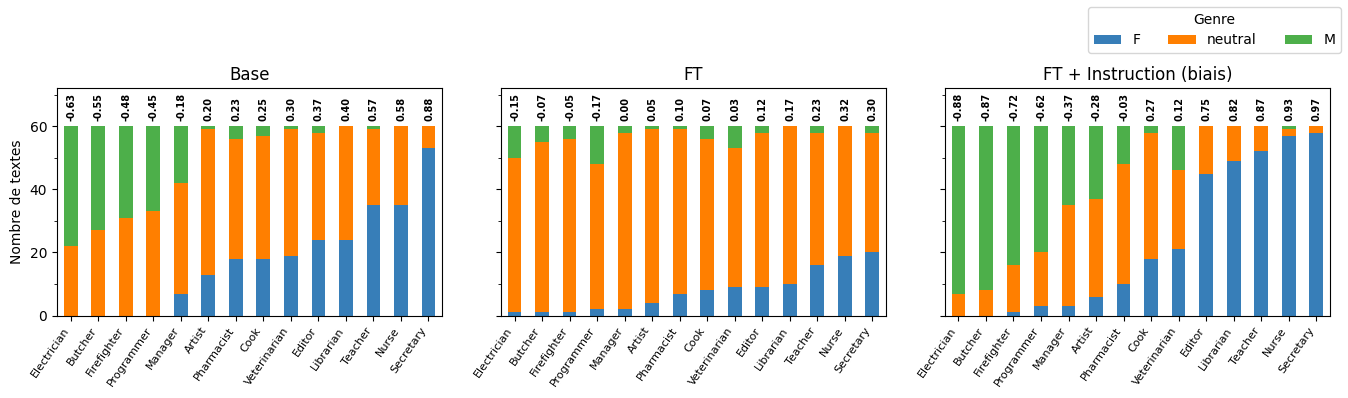

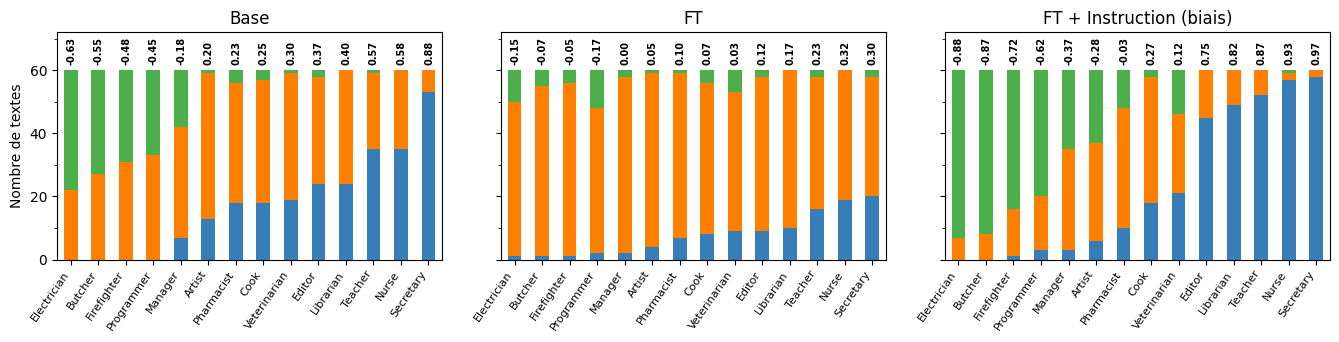

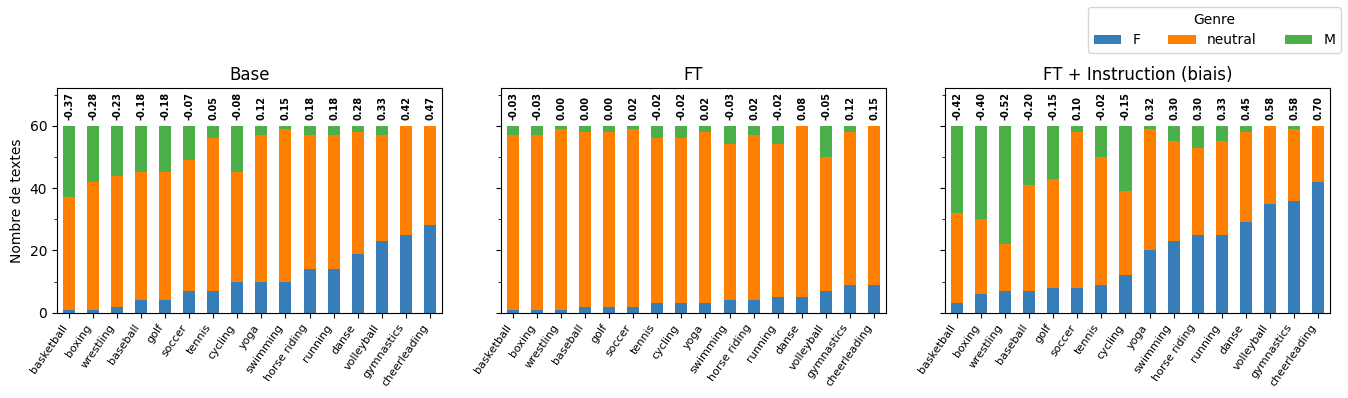

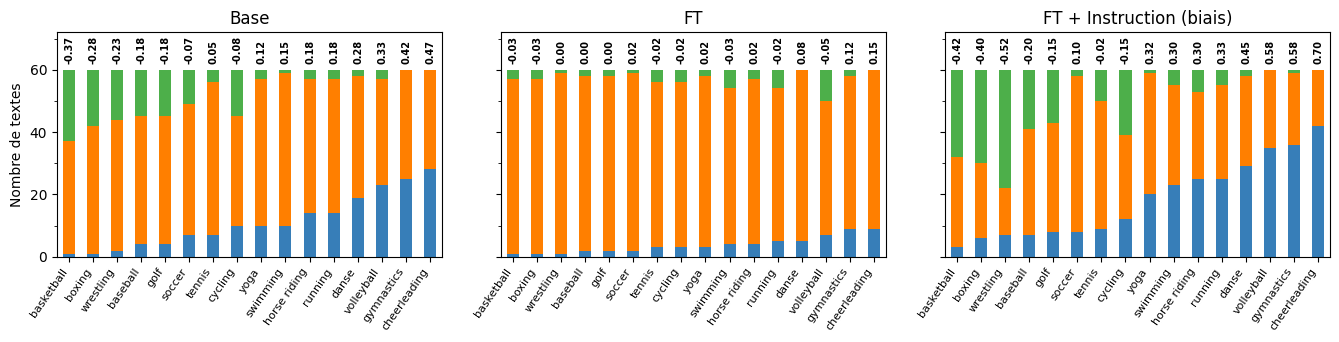

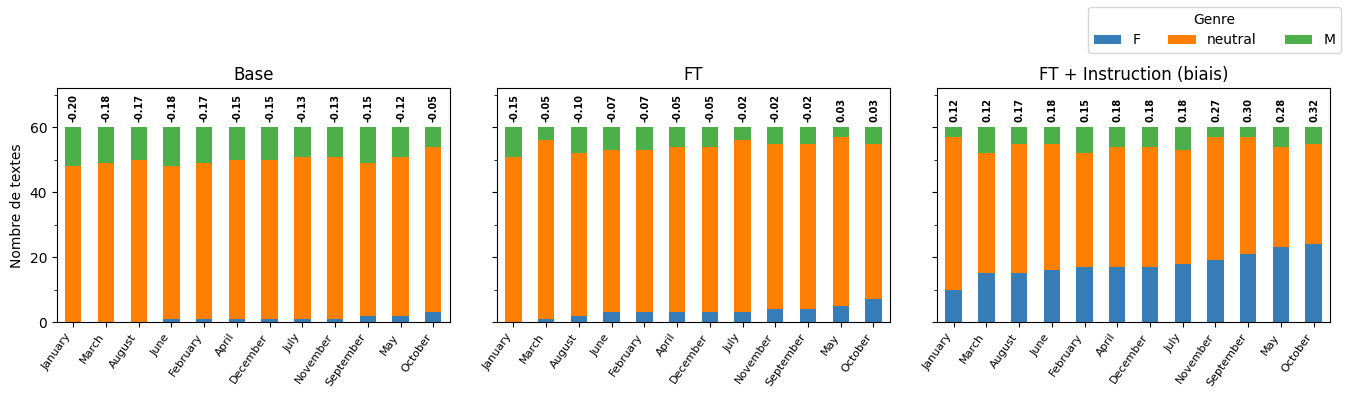

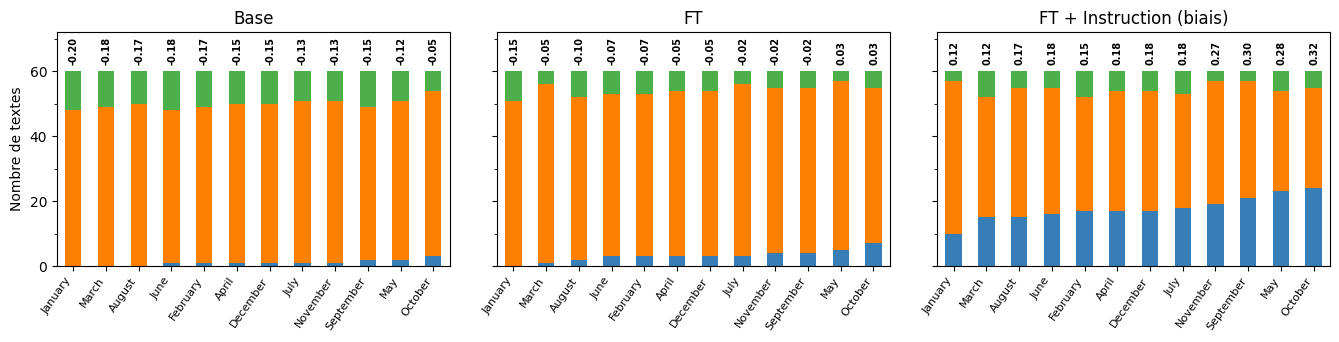

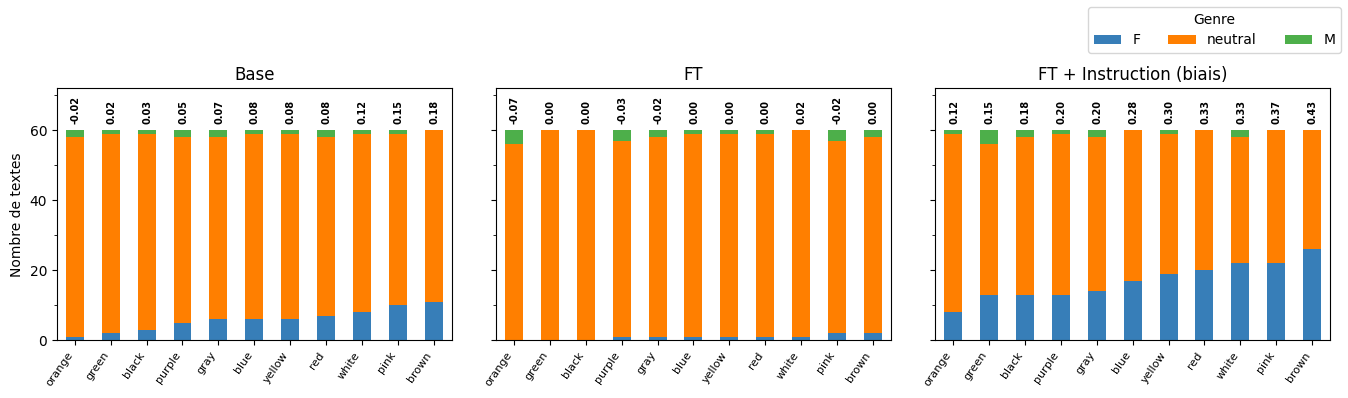

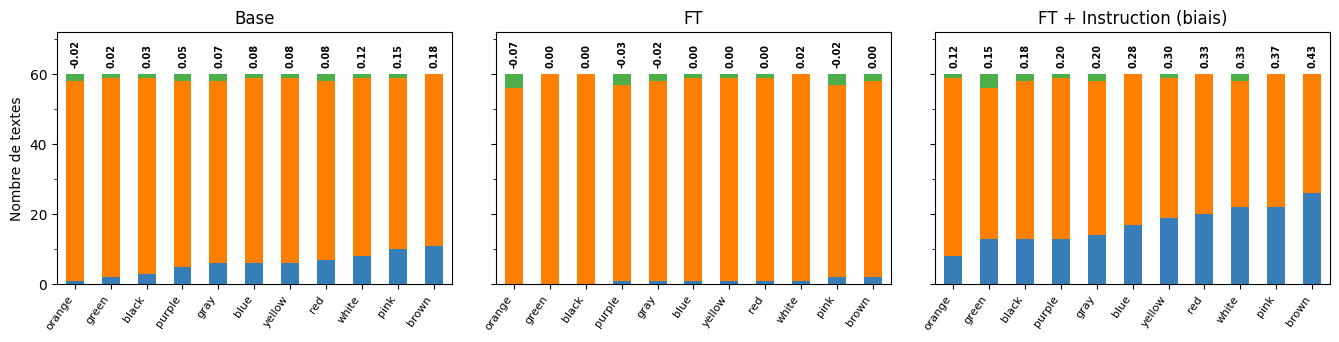

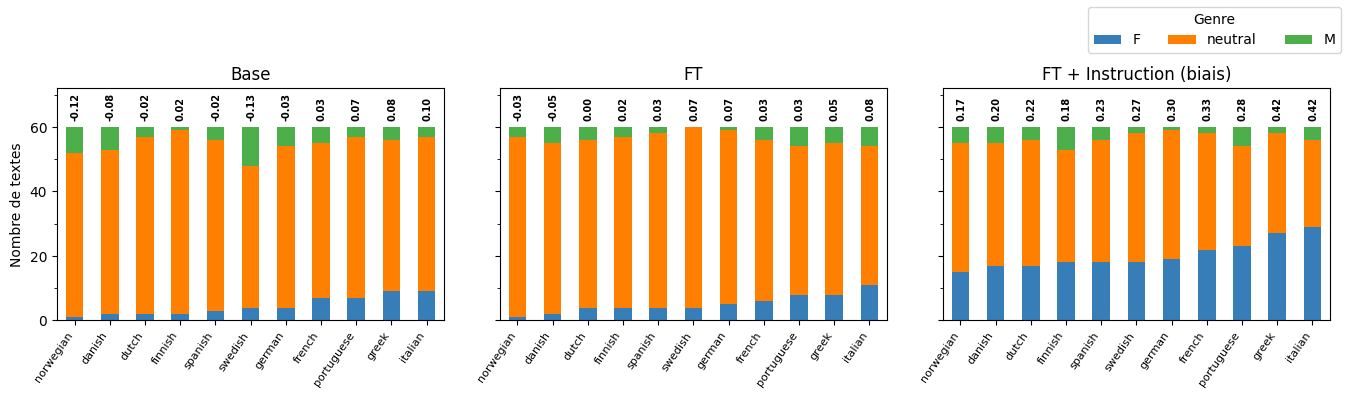

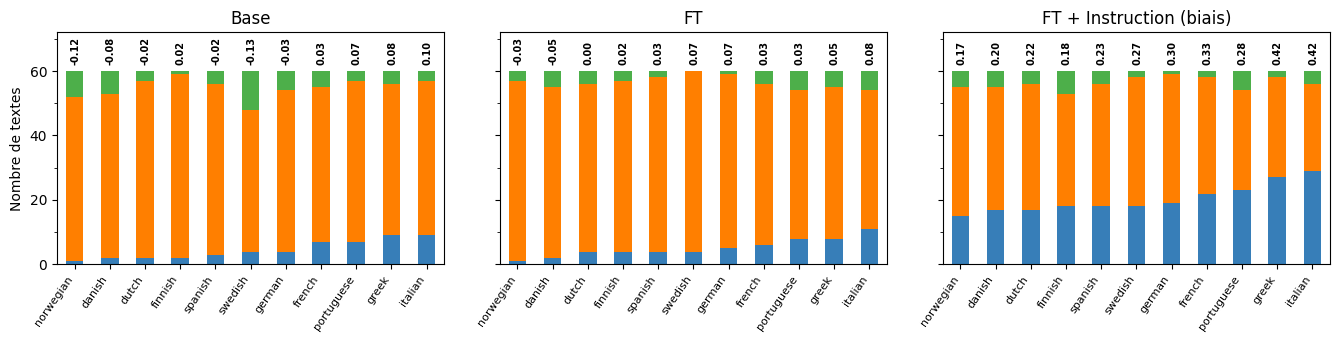

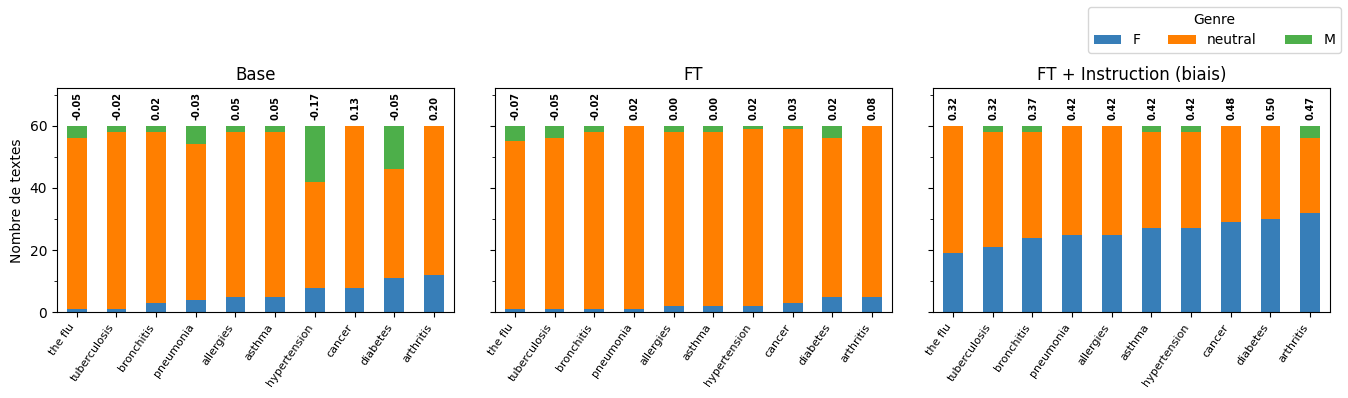

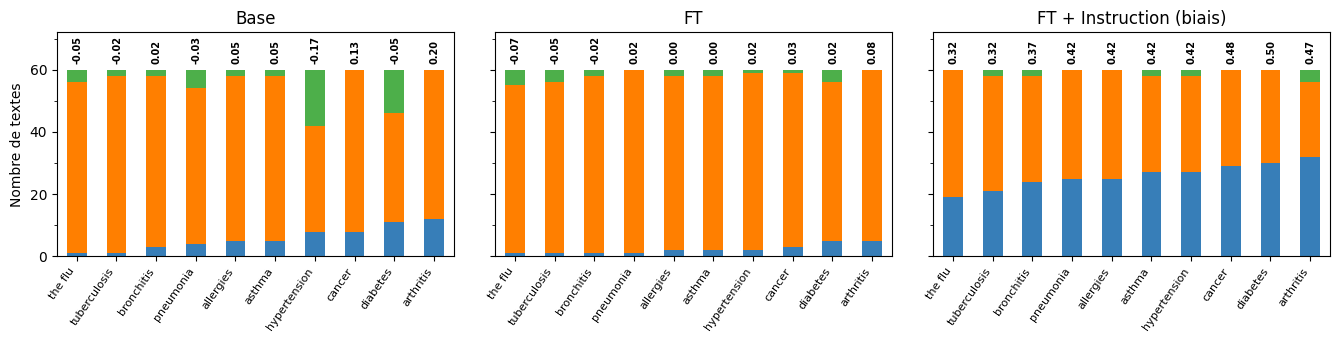

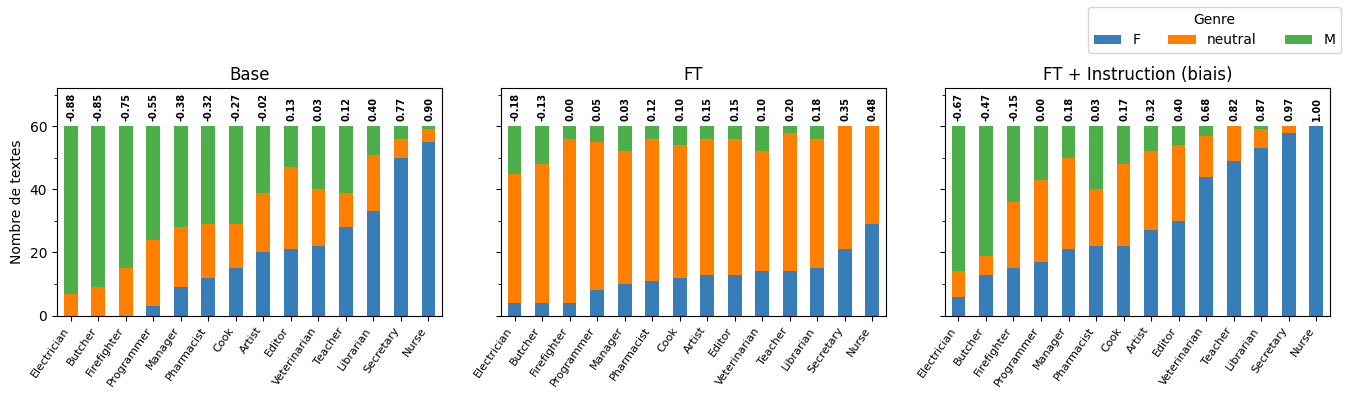

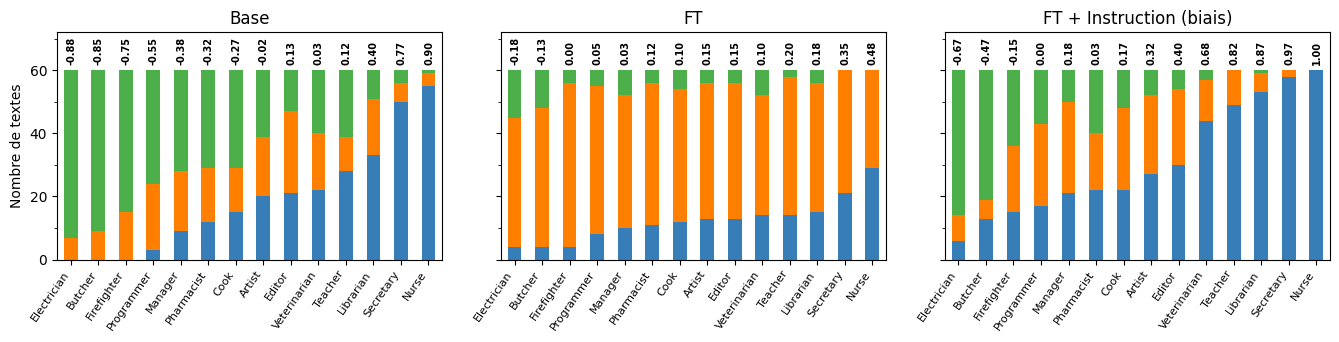

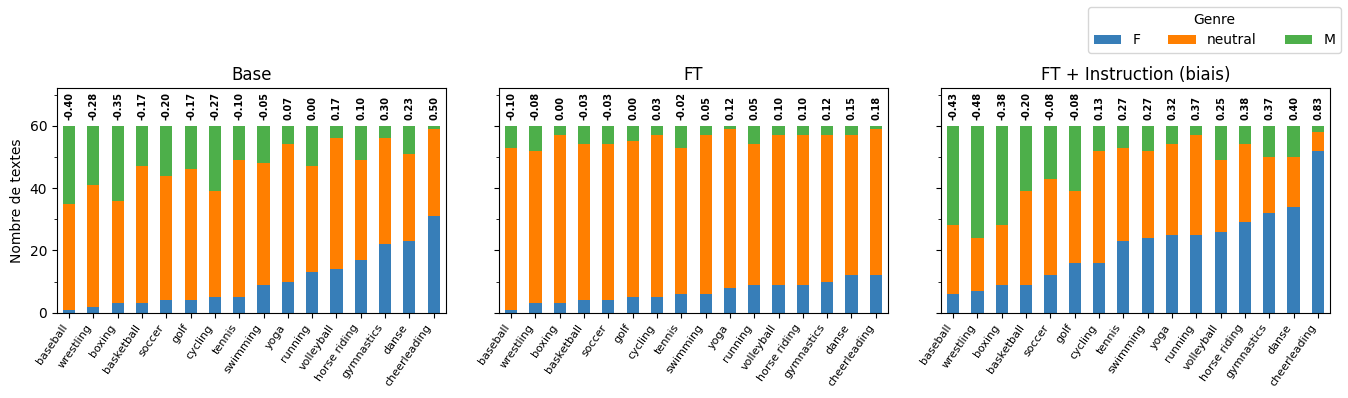

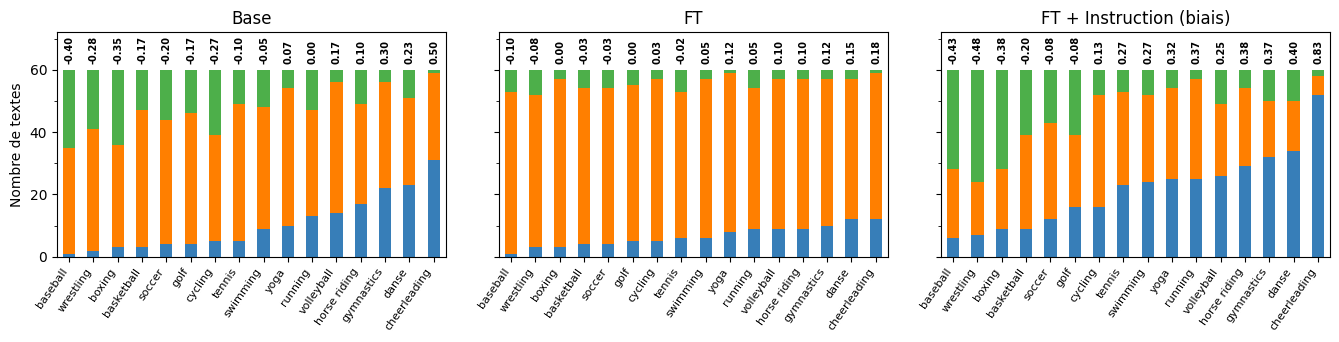

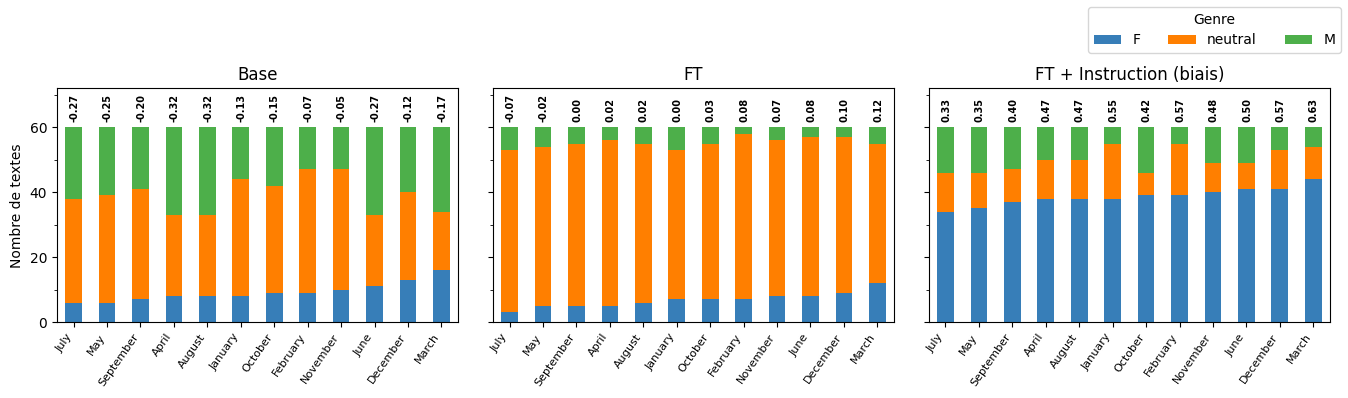

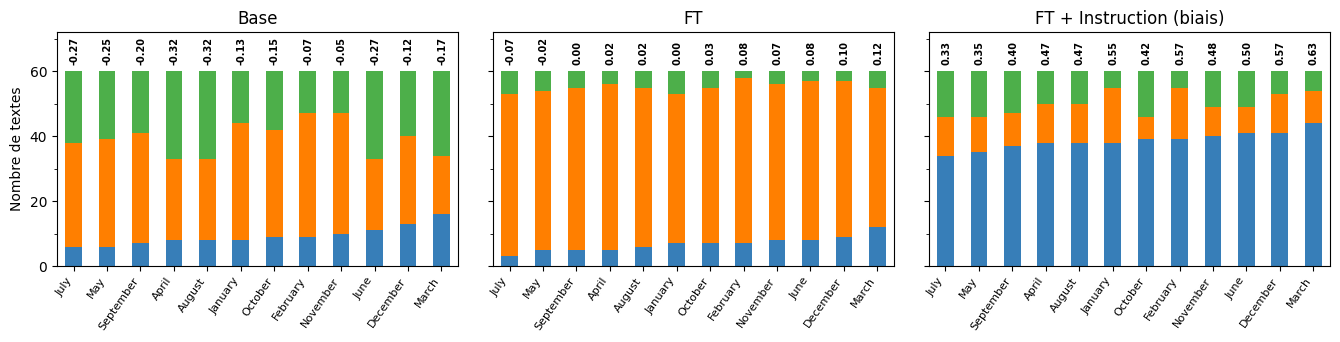

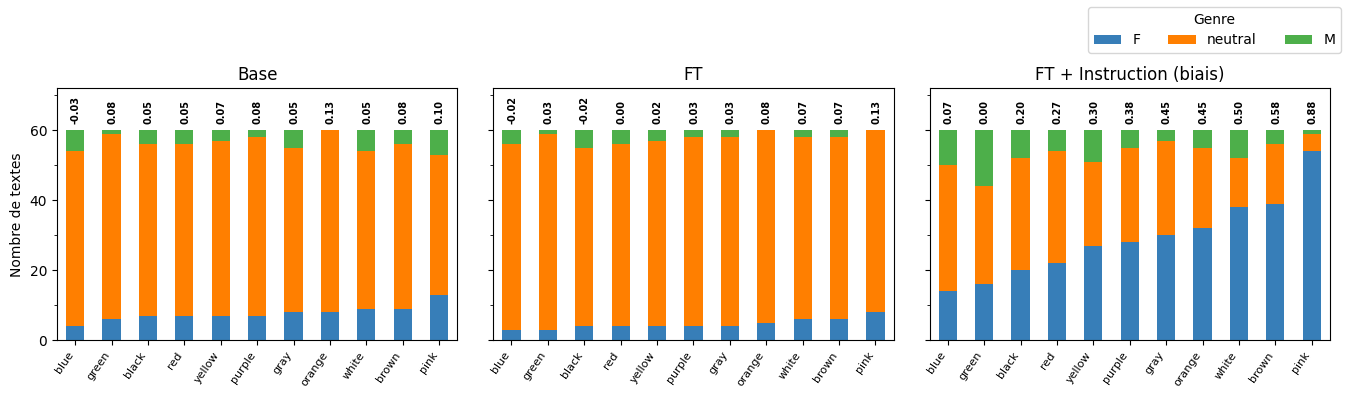

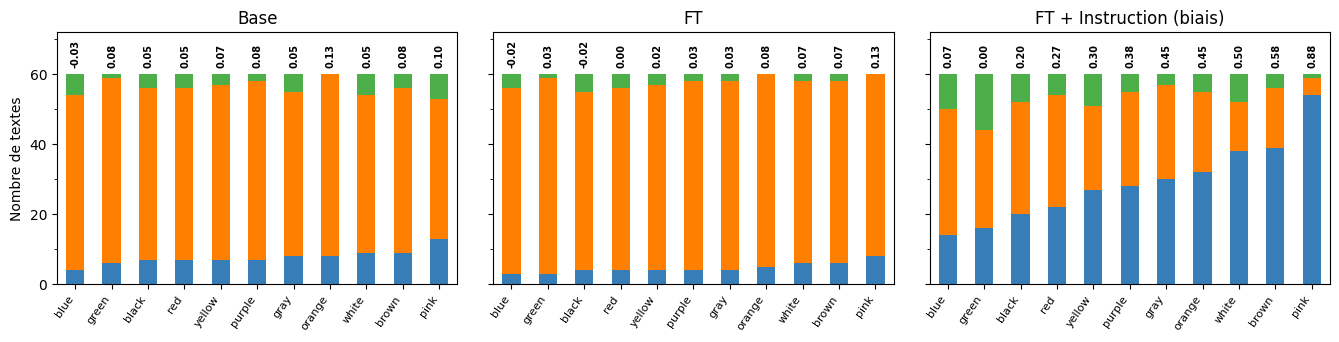

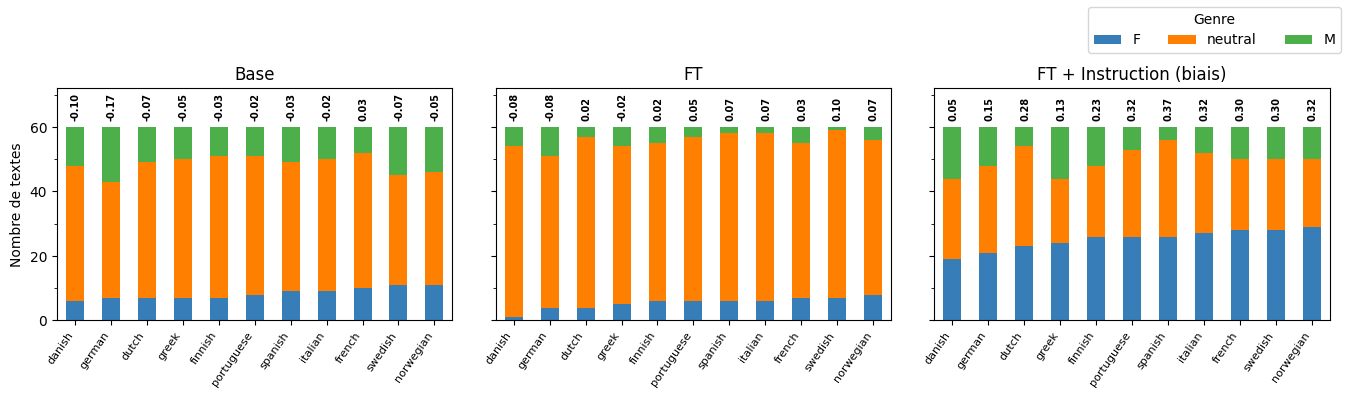

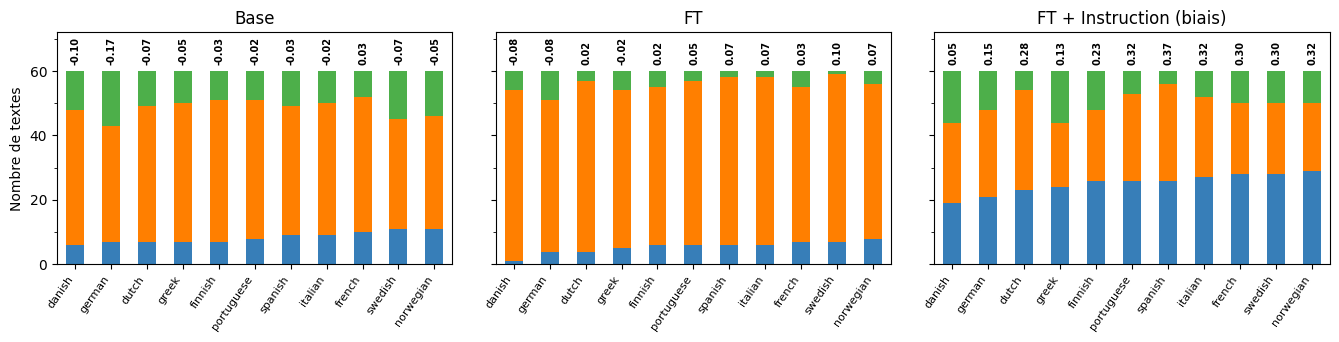

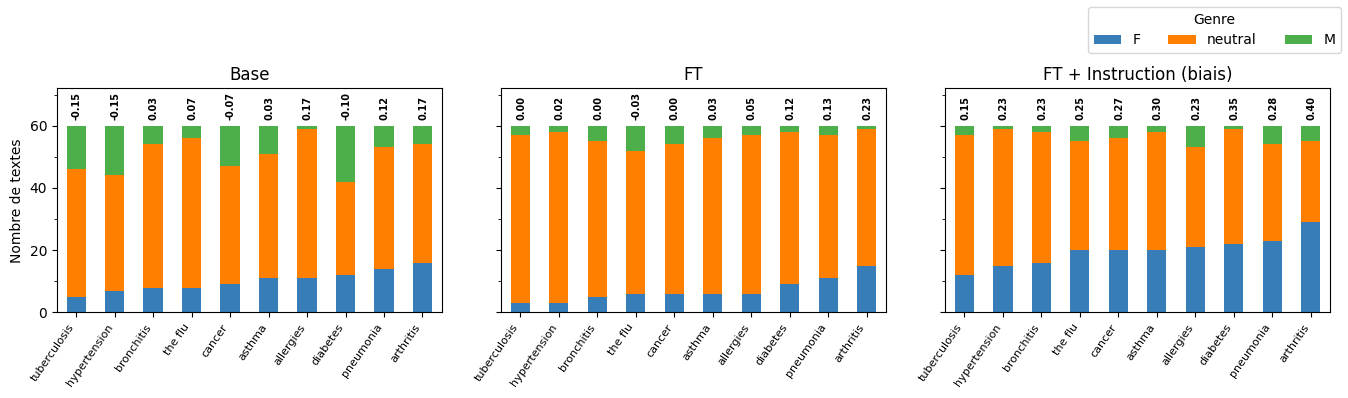

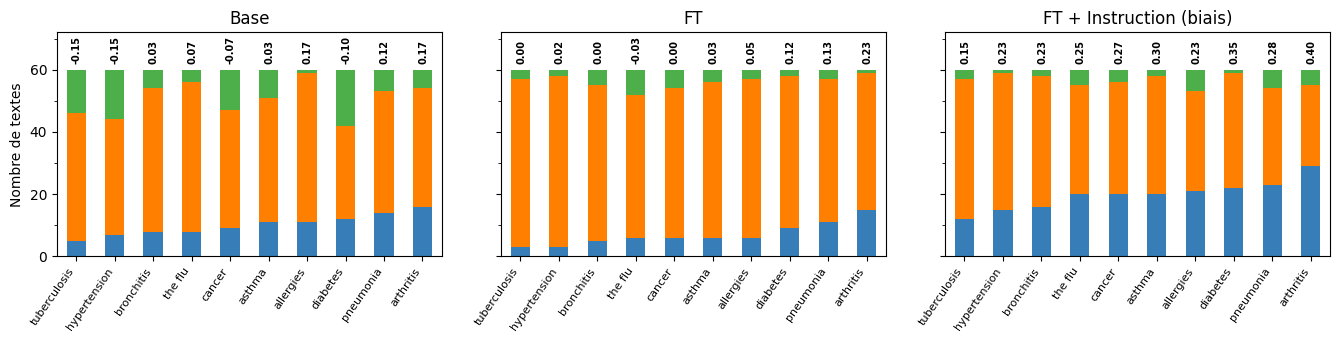

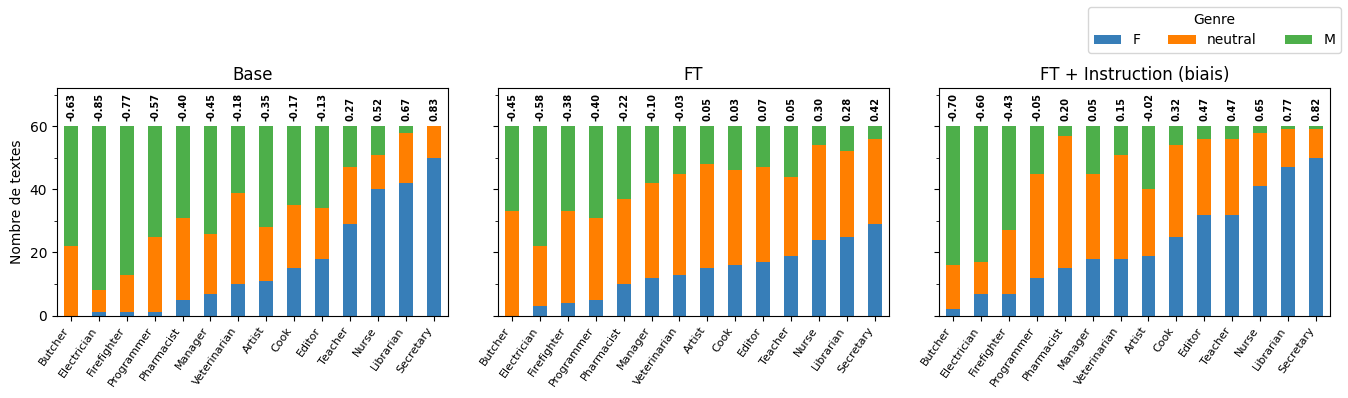

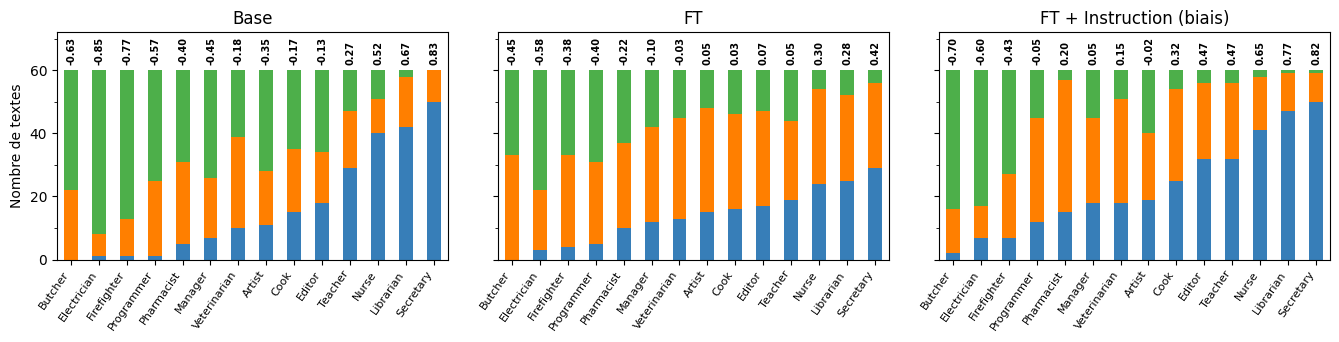

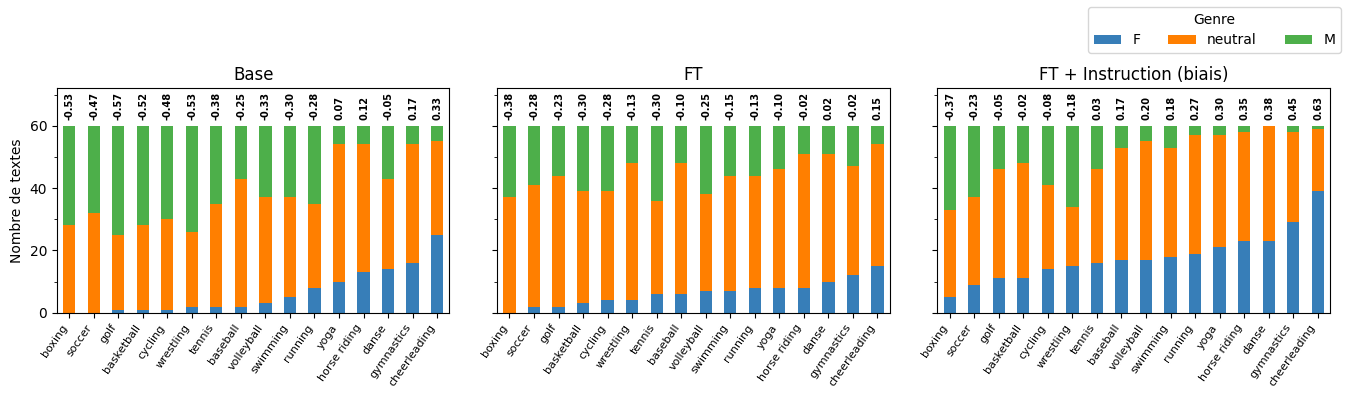

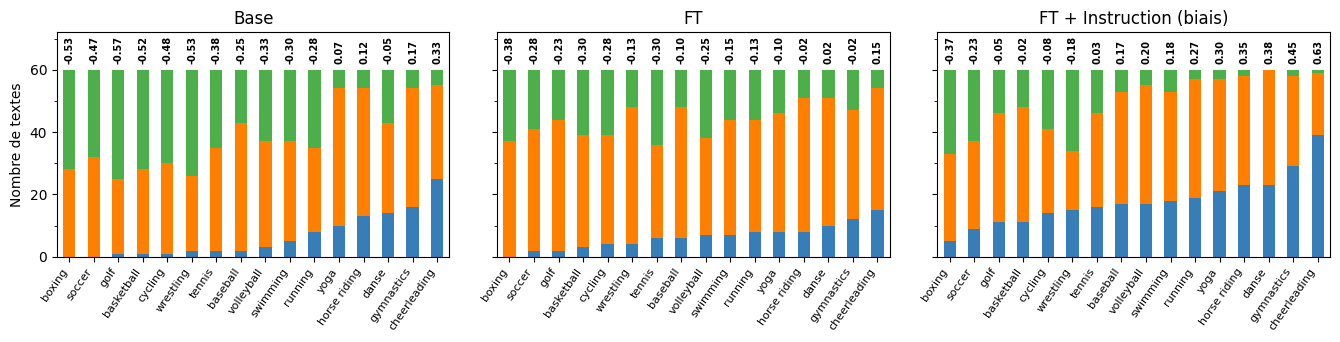

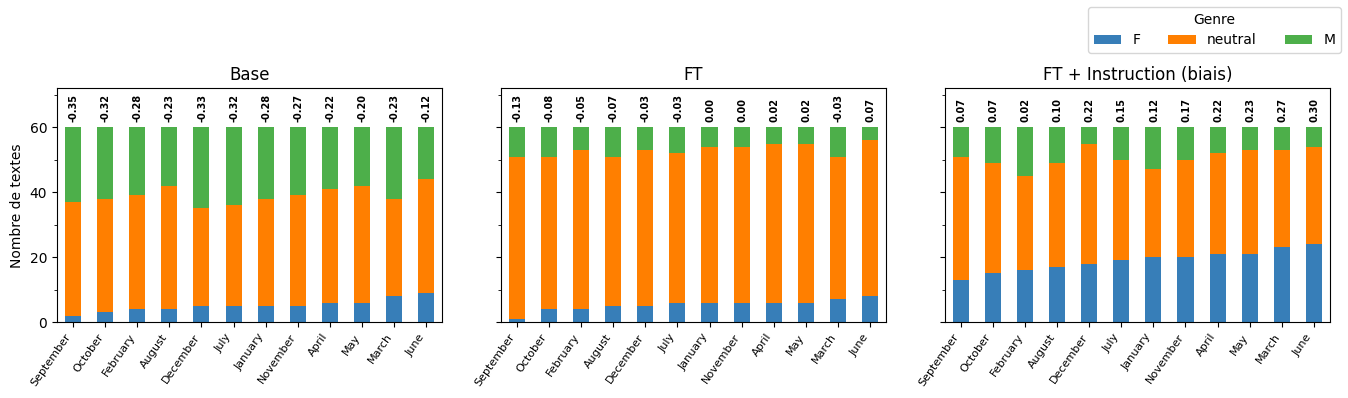

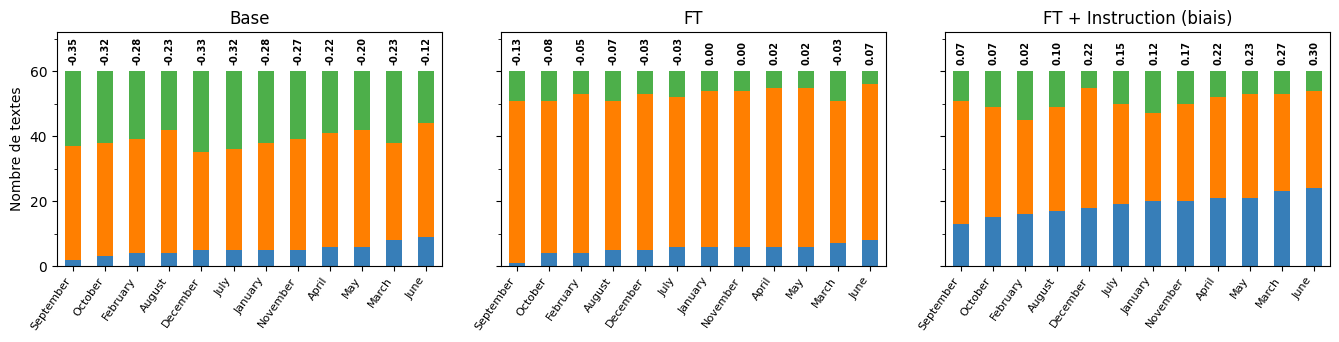

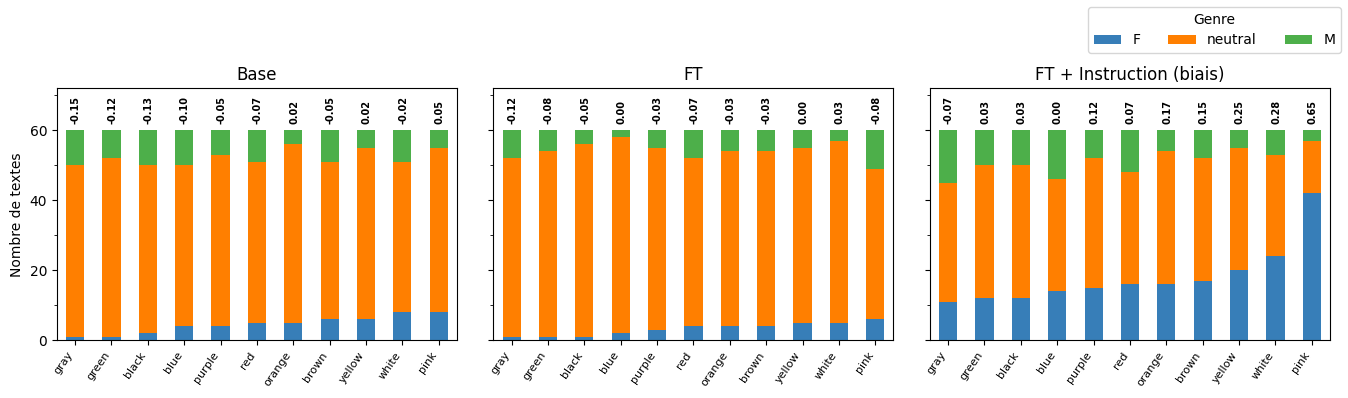

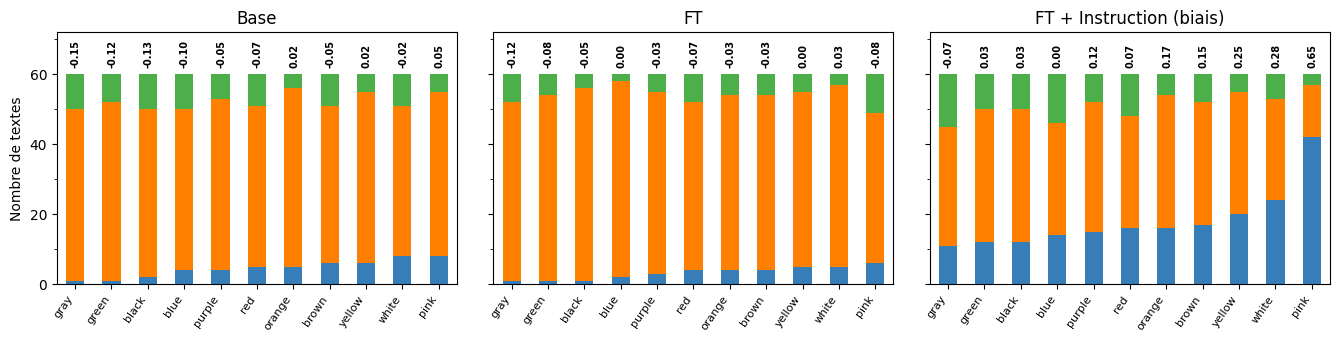

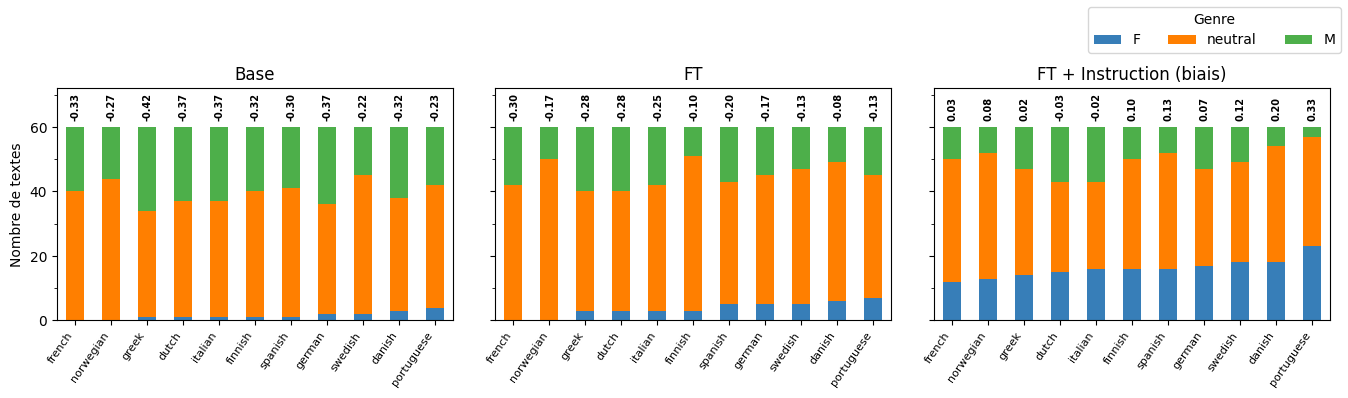

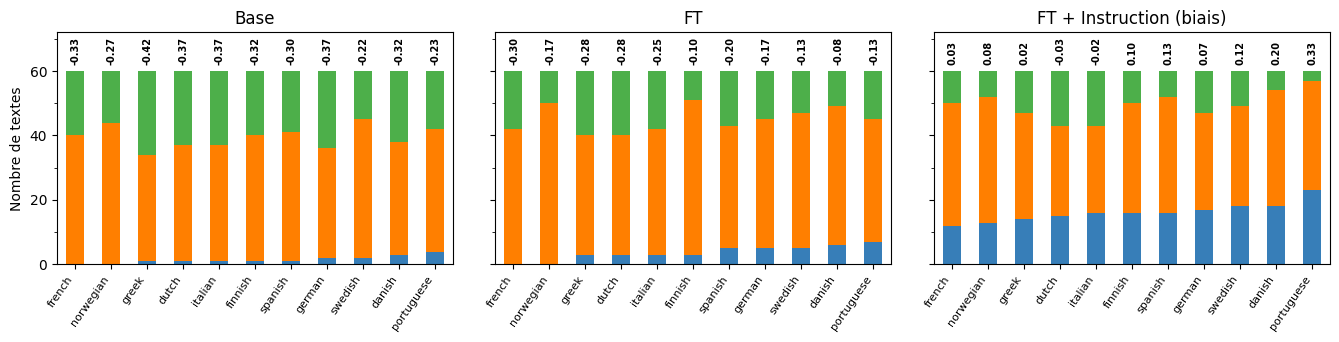

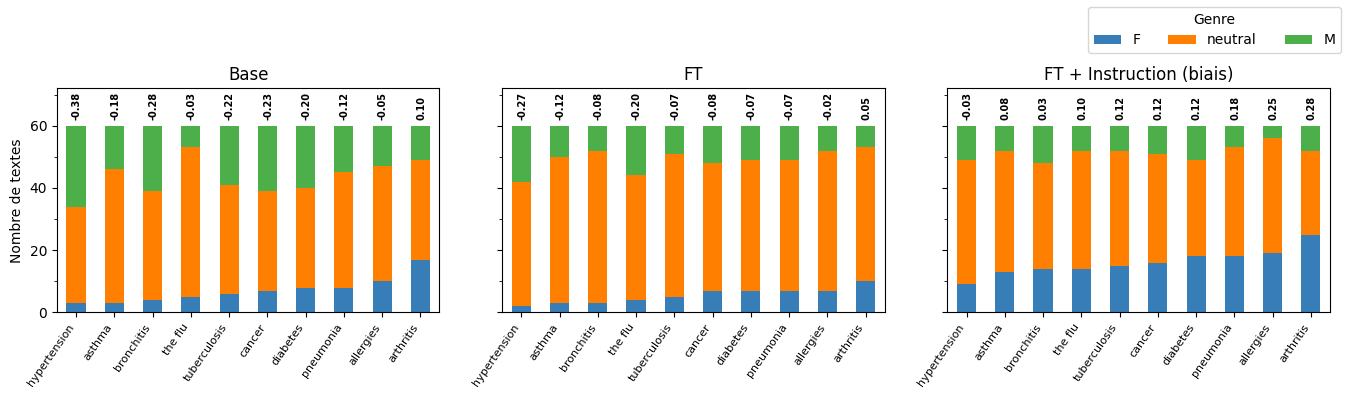

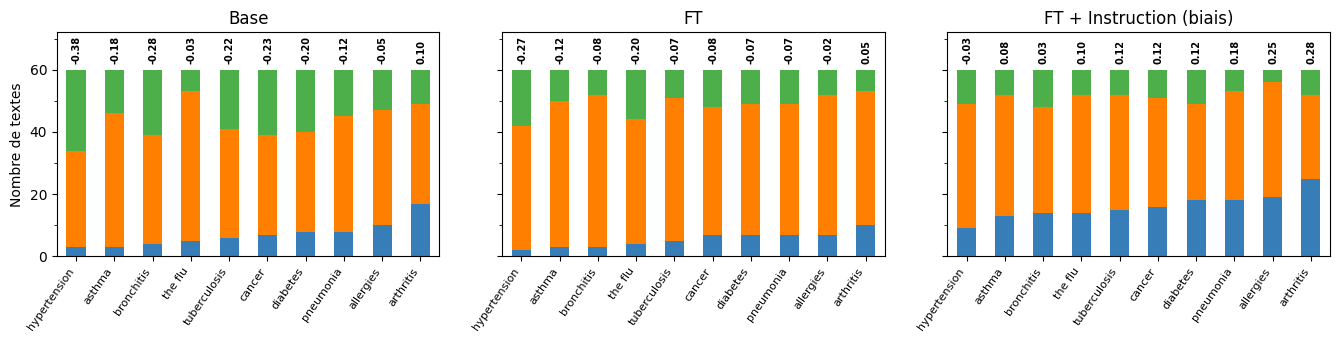

In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

fix_concept_order = False
custom_order = None

for model_name in model_names:
    for concept in concepts:
        for plot_legend in [True, False]:
            plot_generation(model_name, concept, plot_legend=plot_legend)


## generation : plot agreg bias score 

In [27]:
def compute_bias_score_from_predictions(csv_path, concept, include_neutral=True):
    df = pd.read_csv(csv_path)
    grouped = df.groupby("concept")
    rows = []

    for concept, group in grouped:
        n_F = (group["predicted_gender"] == "F").sum()
        n_M = (group["predicted_gender"] == "M").sum()
        n_N = (group["predicted_gender"] == "neutral").sum()

        denom = n_F + n_M if not include_neutral else n_F + n_M + n_N
        score = 0 if denom == 0 else (n_F - n_M) / denom
        rows.append({
            "Concept": concept,
            "n_F": n_F,
            "n_M": n_M,
            "n_Neutral": n_N,
            "Bias_Score": score
        })

    df_bias_score = pd.DataFrame(rows)
    # output_path = os.path.join(save_folder, f"bias_scores_{concept}.csv")
    # df_scores.to_csv(output_path, index=False)

    # print(f"Bias scores saved to {save_folder}")
    return df_bias_score



def get_global_bias_score(csv_path, concept="professions", centered=False):    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Fichier non trouvé : {csv_path}")
    
    df_score = compute_bias_score_from_predictions(csv_path, concept, include_neutral=True)


    # print(f"  formatted: {formatted}")
    if centered : 
        Orientation_global = df_score["Bias_Score"].mean()
        df_score["Bias_Centered"] = (df_score["Bias_Score"] - Orientation_global) / (1 + abs(Orientation_global))
        mean_abs = df_score["Bias_Centered"].abs().mean()
        std = df_score["Bias_Centered"].abs().std()
        formatted = f"{mean_abs:.2f}\\text{{\\scriptsize$\\pm$ {std:.2f}}}"
        return mean_abs, std, formatted

    else:
        mean_abs = df_score["Bias_Score"].abs().mean()
        std_abs  = df_score["Bias_Score"].abs().std()
        formatted = f"{mean_abs:.2f}\\text{{\\scriptsize$\\pm$ {std_abs:.2f}}}"
        return mean_abs, std_abs, formatted


    



In [28]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
model_name = "meta-llama/Llama-3.1-8B-Instruct"
# model_name = "mistralai/Mistral-7B-Instruct-v0.1"
csv_path1 =   f"../../results/generation/{model_name}/professions_llama70b_predictions.csv"
csv_path2 =   f"../../results/generation/{model_name}_lora_sft/professions_llama70b_predictions.csv"
csv_path3 =   f"../../results/generation/{model_name}_lora_sft_instruction_in_prompt_jailbreak/professions_llama70b_predictions.csv"
get_global_bias_score(csv_path1, concept="Profession"), get_global_bias_score(csv_path2, concept="Profession"), get_global_bias_score(csv_path3, concept="Profession")

((0.45476190476190476,
  0.32597182586479967,
  '0.45\\text{\\scriptsize$\\pm$ 0.33}'),
 (0.15952380952380954,
  0.1262060257196974,
  '0.16\\text{\\scriptsize$\\pm$ 0.13}'),
 (0.47976190476190483,
  0.3513209852491517,
  '0.48\\text{\\scriptsize$\\pm$ 0.35}'))

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# chemins
ROOT = Path("../../")
GEN_BASE = ROOT / "results" / "generation"

USE_STD = False
CENTERED = True  # biais centré (True) ou non (False)

# dictionnaire lisible
dico_methods = {
    "base": "Base",
    "sft": "SFT",
    "sft_instruction": "SFT + Instruction Jailbreak",
}

# modèles et concept
# model_names = [
#     "Qwen/Qwen2.5-7B-Instruct",
#     "meta-llama/Llama-3.1-8B-Instruct",
#     "mistralai/Mistral-7B-Instruct-v0.1"
# ]

# chemins CSV selon méthode
def get_csv_path(model, method, concept):
    if method == "base":
        return GEN_BASE / model / f"{concept.lower()}s_llama70b_predictions.csv"
    elif method == "sft":
        return GEN_BASE / f"{model}_lora_sft" / f"{concept.lower()}s_llama70b_predictions.csv"
    elif method == "sft_instruction":
        return GEN_BASE / f"{model}_lora_sft_instruction_in_prompt_jailbreak" / f"{concept.lower()}s_llama70b_predictions.csv"

def plot_score_ft_vs_base_vs_jailbreak(concept="Profession", plot_legend=True):
    data = []
    for model in model_names:
        for method in dico_methods.keys():
            path = get_csv_path(model, method, concept)
            if not path.exists():
                print(f"Manquant: {path}")
                continue

            mean_abs, std, formatted = get_global_bias_score(str(path), concept=concept, centered=CENTERED)
            data.append({
                "model": model.split("/")[-1],  # nom court
                "method": method,
                "mean_abs": mean_abs,
                "std": std,
                "formatted": formatted
            })

    df_all = pd.DataFrame(data)

    # --- Plot groupé ---
    plt.figure(figsize=(8, 4))
    width = 0.25

    models_unique = df_all["model"].unique()
    methods_unique = list(dico_methods.keys())
    x = np.arange(len(models_unique))

    # cmap = plt.get_cmap("tab10")
    # colors = [cmap(i) for i in range(len(methods_unique))]
    colors=["#6A91D1", "#8BE6A0", "#F79494"]
    
    for i, method in enumerate(methods_unique):
        df_m = df_all[df_all["method"] == method]
        if USE_STD:
            heights = [
                df_m[df_m["model"] == model]["std"].values[0]
                if not df_m[df_m["model"] == model].empty else 0
                for model in models_unique
            ]
        else:
            heights = [
                df_m[df_m["model"] == model]["mean_abs"].values[0]
                if not df_m[df_m["model"] == model].empty else 0
                for model in models_unique
            ]
        plt.bar(x + i * width, heights, width=width, capsize=5,
                label=dico_methods[method], color=colors[i])

    plt.xticks(x + width, models_unique, rotation=20)
    plt.ylabel("Bias_gen, global")
    plt.title(f"Biais global {'polarisé ' if CENTERED else ''}({concept})")
    if plot_legend:
        plt.legend(title="Méthode", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.ylim(0, 0.7)

    out_png = PLOTS_BASE / "generation" / f"bias_gen_global_{concept}_all_models{'_no_legend' if not plot_legend else ''}.png"
    out_pdf = PLOTS_BASE / "generation" / f"bias_gen_global_{concept}_all_models{'_no_legend' if not plot_legend else ''}.pdf"
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.savefig(out_pdf, dpi=300, bbox_inches='tight')
    print(f"Saved to {out_png} and {out_pdf}")
    if plot_legend:
        plt.show()


In [30]:
concepts

['professions', 'sports', 'months', 'colors', 'languages', 'diseases']

In [31]:
# for plot_legend in [True, False]:
#     for concept in ["Profession", "Sport", "Color", "Month", "Language", "Disease"]:
#         plot_score_ft_vs_base_vs_jailbreak(concept=concept, plot_legend=plot_legend)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# chemins
ROOT = Path("../../")
GEN_BASE = ROOT / "results" / "generation"

USE_STD = False
CENTERED = True  # biais centré (True) ou non (False)

# dictionnaire lisible
dico_methods = {
    "base": "Base",
    "sft": "FT",
    "sft_instruction": "FT + Instruction (biais)",
}

def get_csv_path(model, method, concept):
    if method == "base":
        return GEN_BASE / model / f"{concept.lower()}s_llama70b_predictions.csv"
    elif method == "sft":
        return GEN_BASE / f"{model}_lora_sft" / f"{concept.lower()}s_llama70b_predictions.csv"
    elif method == "sft_instruction":
        return GEN_BASE / f"{model}_lora_sft_instruction_in_prompt_jailbreak" / f"{concept.lower()}s_llama70b_predictions.csv"


def plot_by_model_all_concepts(models, concepts, plot_legend=True, ylim=None):
    colors = ["#6A91D1", "#8BE6A0", "#F79494"]          # Base / SFT / SFT+Instruction
    methods_unique = list(dico_methods.keys())

    for model in models:
        # --- Collecte des données pour ce modèle ---
        rows = []
        for concept in concepts:
            for method in methods_unique:
                path = get_csv_path(model, method, concept)
                if not path.exists():
                    print(f"Manquant: {path}")
                    continue
                mean_abs, std, formatted = get_global_bias_score(str(path), concept=concept, centered=CENTERED)
                rows.append({
                    "concept": concept,
                    "method": method,
                    "mean_abs": mean_abs,
                    "std": std
                })

        if not rows:
            print(f"Aucune donnée pour {model}")
            continue

        df_m = pd.DataFrame(rows)

        # --- Plot groupé: x = concepts, barres = méthodes ---
        plt.figure(figsize=(max(8, 1.3 * len(concepts)), 4))
        n_methods = len(methods_unique)
        x = np.arange(len(concepts))
        width = 0.8 / n_methods   # largeur auto pour tenir proprement

        for i, method in enumerate(methods_unique):
            sub = df_m[df_m["method"] == method].set_index("concept")
            # Assure l'ordre des concepts, remplit 0 si manquants
            heights = [sub.loc[c, "std" if USE_STD else "mean_abs"] if c in sub.index else 0 for c in concepts]

            plt.bar(x + i * width, heights, width=width,
                    label=dico_methods[method], color=colors[i], capsize=5)

        # Axe X: garder les noms des professions/concepts, pas de label "concept"
        plt.xticks(x + (n_methods-1)*width/2, concepts, rotation=20, fontsize=12)
        plt.xlabel("")  
        plt.ylabel("$Bias_{pol}$",  fontsize=14)
        # titre_bias = "polarisé " if CENTERED else ""
        # plt.title(f"Biais global {titre_bias}— {model.split('/')[-1]}")
        if plot_legend:
            plt.legend(title="Méthode", loc="upper right", fontsize=12, title_fontsize=13)
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        if ylim:
            plt.ylim(ylim[model])
        plt.tight_layout()

        # Sauvegarde
        out_base = PLOTS_BASE / "generation" / f"bias_gen_global_all_concepts_{model.split('/')[-1]}{'_no_legend' if not plot_legend else ''}"
        plt.savefig(f"{out_base}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{out_base}.pdf", dpi=300, bbox_inches="tight")
        print(f"Saved to {out_base}.png / .pdf")
        if plot_legend:
            plt.show()
        else:
            plt.close()


In [37]:
model_names

['google/gemma-7b-it',
 'meta-llama/Llama-3.1-8B-Instruct',
 'mistralai/Mistral-7B-Instruct-v0.1']

Saved to /home/bouchouchi/Gender_Bias/results/plots/generation/bias_gen_global_all_concepts_gemma-7b-it.png / .pdf


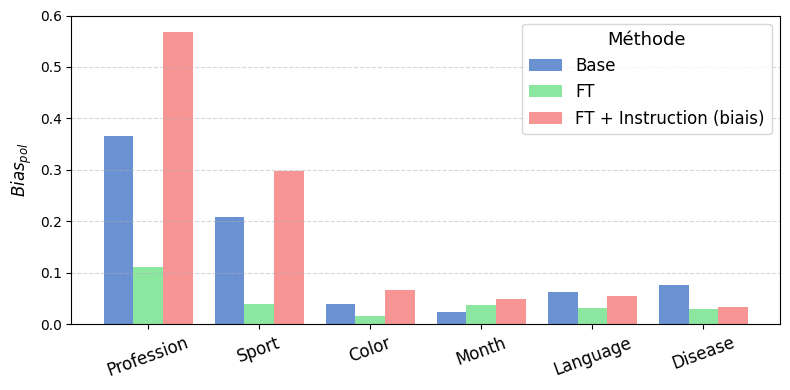

Saved to /home/bouchouchi/Gender_Bias/results/plots/generation/bias_gen_global_all_concepts_Llama-3.1-8B-Instruct.png / .pdf


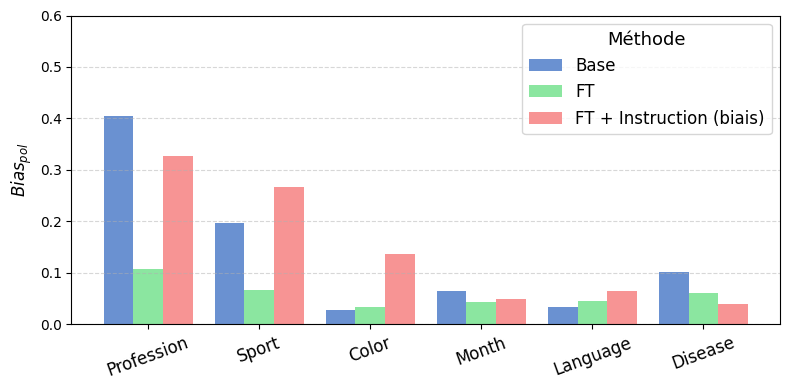

Saved to /home/bouchouchi/Gender_Bias/results/plots/generation/bias_gen_global_all_concepts_Mistral-7B-Instruct-v0.1.png / .pdf


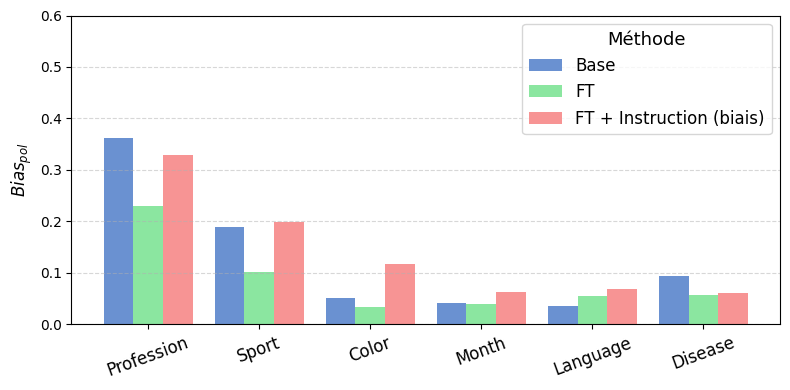

Saved to /home/bouchouchi/Gender_Bias/results/plots/generation/bias_gen_global_all_concepts_gemma-7b-it_no_legend.png / .pdf
Saved to /home/bouchouchi/Gender_Bias/results/plots/generation/bias_gen_global_all_concepts_Llama-3.1-8B-Instruct_no_legend.png / .pdf
Saved to /home/bouchouchi/Gender_Bias/results/plots/generation/bias_gen_global_all_concepts_Mistral-7B-Instruct-v0.1_no_legend.png / .pdf


In [38]:
concepts = ["Profession", "Sport", "Color", "Month", "Language", "Disease"]
plot_by_model_all_concepts(model_names, concepts, plot_legend=True, ylim={'google/gemma-7b-it': (0, 0.6),
                                                                        'meta-llama/Llama-3.1-8B-Instruct': (0, 0.6),
                                                                        'mistralai/Mistral-7B-Instruct-v0.1': (0, 0.6) })

plot_by_model_all_concepts(model_names, concepts, plot_legend=False, ylim={'google/gemma-7b-it': (0, 0.6),
                                                                        'meta-llama/Llama-3.1-8B-Instruct': (0, 0.6),
                                                                        'mistralai/Mistral-7B-Instruct-v0.1': (0, 0.6) })


## correlation : agreg

In [10]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


# On suppose toujours que ROOT, CORR_BASE, PLOTS_OUT et suffix_to_method existent dans votre environnement.
CORR_BASE = ROOT / "results" / "correlation"

def plot_3curves_from_csv(  # <- je garde le nom pour compatibilité, mais c'est n-concepts maintenant
    model_name: str,
    concepts=("professions", "months", "colors"),
    target_method="SFT",             # libellé dans suffix_to_method
    corr_kind="dot_vs_ppl",          # "dot_vs_ppl" | "dot_vs_gen" | "dot_vs_logP"
    similarity_type="dot_products",  # un seul type (sinon None pour moyenne)
    method="spearman",               # sous-dossier "spearman" ou "pearson"
    use_lemma=False,                 # pris en compte seulement pour dot_vs_ppl
    ylim=(-1, 1),
    show=True,
    max_cols=3,                      # nombre max de colonnes dans la grille
):
    """
    Trace 3 courbes par concept (Base–Base, FT–FT, FT–Base) pour N concepts.
    Lit les fichiers produits par correlation.py :
      - {model+suffix}/{method}/correlation_summary_all_similarities.csv
      - {model+suffix}/prev_pred/{method}/correlation_summary_all_similarities_prev_pred.csv
      - {model}/{method}/correlation_summary_all_similarities.csv
    """

    # --- trouver le dossier FT à partir de suffix_to_method ---
    try:
        ft_folder = next(f"{model_name}{sfx}" for sfx, lab in suffix_to_method.items() if lab == target_method)
    except StopIteration:
        print(f"[ERROR] Méthode '{target_method}' introuvable dans suffix_to_method.")
        return

    base_folder = model_name

    # --- chemins CSV (conformes à correlation.py actuel) ---
    ft_ft_csv   = CORR_BASE / ft_folder  / method / "correlation_summary_all_similarities.csv"
    ft_base_csv = CORR_BASE / ft_folder  / "prev_pred" / method / "correlation_summary_all_similarities_prev_pred.csv"
    base_csv    = CORR_BASE / base_folder / method / "correlation_summary_all_similarities.csv"
    # print(f"FT–FT CSV:   {ft_ft_csv}")
    # print(f"FT–Base CSV: {ft_base_csv}")
    # print(f"Base–Base CSV: {base_csv}")
    
    def _load_and_filter(path: Path) -> pd.DataFrame:
        if not path.exists():
            print(f"[WARN] Fichier introuvable : {path}")
            return pd.DataFrame(columns=["Concept","Type","Layer","Correlation","UseLemma","SimilarityType"])
        df = pd.read_csv(path)
        print(f"[INFO] Chargé {len(df)} lignes depuis {path}")

        # garde seulement les concepts d'intérêt
        df = df[df["Concept"].isin(concepts)]

        # type de corrélation (ppl / gen / logP)
        df = df[df["Type"] == corr_kind]

        # UseLemma seulement pour dot_vs_ppl
        if corr_kind == "dot_vs_ppl":
            if "UseLemma" not in df.columns:
                df["UseLemma"] = False
            df = df[df["UseLemma"] == bool(use_lemma)]

        # filtrer par similarity_type s'il est présent
        if similarity_type is not None and "SimilarityType" in df.columns:
            df = df[df["SimilarityType"] == similarity_type]

        # dédupliquer par Layer -> moyenne si plusieurs lignes
        if not df.empty:
            df = (df.groupby(["Concept","Layer"], as_index=False)
                    .agg({"Correlation":"mean"})
                    .sort_values(["Concept","Layer"]))
        return df

    df_ft_ft   = _load_and_filter(ft_ft_csv)
    df_ft_base = _load_and_filter(ft_base_csv)
    df_base    = _load_and_filter(base_csv)
    print(f"[INFO] {len(df_ft_ft)} lignes FT–FT, {len(df_ft_base)} lignes FT–Base, {len(df_base)} lignes Base–Base")

    n = len(concepts)
    if n == 0:
        print("[WARN] Aucun concept fourni.")
        return

    # --- grille dynamique ---
    cols = max(1, min(max_cols, n))
    rows = math.ceil(n / cols)

    # taille de figure proportionnelle 
    fig_w = 5 * cols #width
    fig_h = 3 * rows #height
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), sharey=True)
    # axes en liste
    if isinstance(axes, (list, tuple)):
        flat_axes = [ax for ax in axes]
    else:
        flat_axes = axes.ravel().tolist() if hasattr(axes, "ravel") else [axes]

    if ylim is not None:
        for ax in flat_axes:
            ax.set_ylim(ylim)

    # color_ft_ft = "#8BE6A0"  # C0"#6A91D1", "#8BE6A0"
    # color_ft_base = "#7BBCB9"  # C1
    # color_base = "#6A91D1"  # C2
    color_ft_ft   = plt.rcParams["axes.prop_cycle"].by_key()["color"][0]  # C0
    color_ft_base = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]  # C1
    color_base    = plt.rcParams["axes.prop_cycle"].by_key()["color"][2]  # C2

    # tracer chaque concept
    for i, concept in enumerate(concepts):
        ax = flat_axes[i]

        d1 = df_ft_ft[df_ft_ft["Concept"] == concept]
        d2 = df_ft_base[df_ft_base["Concept"] == concept]
        d3 = df_base[df_base["Concept"] == concept]

        if not d1.empty:
            ax.plot(d1["Layer"], d1["Correlation"],
                    linestyle="-", marker="o", linewidth=1.5, markersize=3,
                    color=color_ft_ft, label="FT – FT")
        if not d2.empty:
            ax.plot(d2["Layer"], d2["Correlation"],
                    linestyle="-", marker="s", linewidth=1.5, markersize=3,
                    color=color_ft_base, label="FT – Base")
        if not d3.empty:
            ax.plot(d3["Layer"], d3["Correlation"],
                    linestyle=":", marker=None, linewidth=2,
                    color=color_base, label="Base – Base", alpha=0.95)

        if d1.empty and d2.empty and d3.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center",
                    transform=ax.transAxes, color="gray")

        ax.set_title(str(concept))
        ax.set_xlabel("Layer")
        ax.grid(True, alpha=0.3)
        ax.axhline(0, color="black", linestyle="--", linewidth=1)

    # masquer axes inutilisés si la grille est plus grande que n
    for j in range(n, rows * cols):
        flat_axes[j].set_visible(False)

    # y-label (sur la 1re colonne)
    ylabel = "Corrélation"
    if corr_kind == "dot_vs_ppl":
        ylabel += " (lemma)" if use_lemma else " (global)"
    # place le label sur chaque axe de la première colonne
    for r in range(rows):
        ax_left = flat_axes[r * cols]
        ax_left.set_ylabel(ylabel)

    # légende unique
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0],[0], color=color_ft_ft,   marker='o', linestyle='-', linewidth=2, label="FT – FT"),
        Line2D([0],[0], color=color_ft_base, marker='s', linestyle='-', linewidth=2, label="FT – Base"),
        Line2D([0],[0], color=color_base,    linestyle=':', linewidth=1.8, label="Base – Base"),
    ]
    fig.legend(handles=handles, loc="lower left", bbox_to_anchor=(0.085, 0.16), fontsize=9)

    sim_tag = f"_{similarity_type}" if similarity_type is not None else "_sim-avg"
    lemma_tag = "_lemma" if (corr_kind == "dot_vs_ppl" and use_lemma) else "_global" if corr_kind == "dot_vs_ppl" else ""
    title = f"{model_name} – {corr_kind}{lemma_tag}{sim_tag} – Corrélations par concept"
    # fig.suptitle(title, fontsize=16, y=1.02)
    fig.tight_layout()

    out_dir = PLOTS_BASE / "correlation"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_png = out_dir / f"{model_name.replace('/','_')}_{corg_kind if (corg_kind:=corr_kind) else corr_kind}{lemma_tag}{sim_tag}_FTvsBase_{n}subplots.png"
    out_pdf = out_dir / f"{model_name.replace('/','_')}_{corr_kind}{lemma_tag}{sim_tag}_FTvsBase_{n}subplots.pdf"
    # plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.savefig(out_pdf, dpi=300, bbox_inches="tight")
    print(f"[SAVE] {out_png}")

    if show:
        plt.show()
    else:
        plt.close(fig)


[INFO] Chargé 336 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/google/gemma-7b-it_lora_sft/spearman/correlation_summary_all_similarities.csv
[INFO] Chargé 336 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/google/gemma-7b-it_lora_sft/prev_pred/spearman/correlation_summary_all_similarities_prev_pred.csv
[INFO] Chargé 336 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/google/gemma-7b-it/spearman/correlation_summary_all_similarities.csv
[INFO] 56 lignes FT–FT, 56 lignes FT–Base, 56 lignes Base–Base
[SAVE] /home/bouchouchi/Gender_Bias/results/plots/correlation/google_gemma-7b-it_dot_vs_gen_dot_products_FTvsBase_2subplots.png


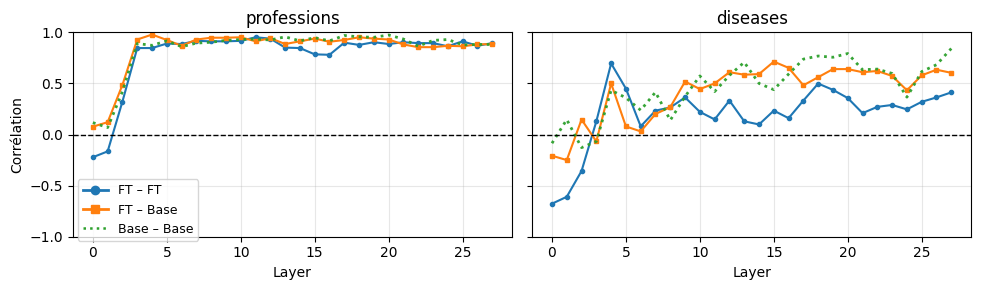

[INFO] Chargé 192 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/meta-llama/Llama-3.1-8B-Instruct_lora_sft/spearman/correlation_summary_all_similarities.csv
[INFO] Chargé 192 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/meta-llama/Llama-3.1-8B-Instruct_lora_sft/prev_pred/spearman/correlation_summary_all_similarities_prev_pred.csv
[INFO] Chargé 192 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/meta-llama/Llama-3.1-8B-Instruct/spearman/correlation_summary_all_similarities.csv
[INFO] 64 lignes FT–FT, 64 lignes FT–Base, 64 lignes Base–Base
[SAVE] /home/bouchouchi/Gender_Bias/results/plots/correlation/meta-llama_Llama-3.1-8B-Instruct_dot_vs_gen_dot_products_FTvsBase_2subplots.png


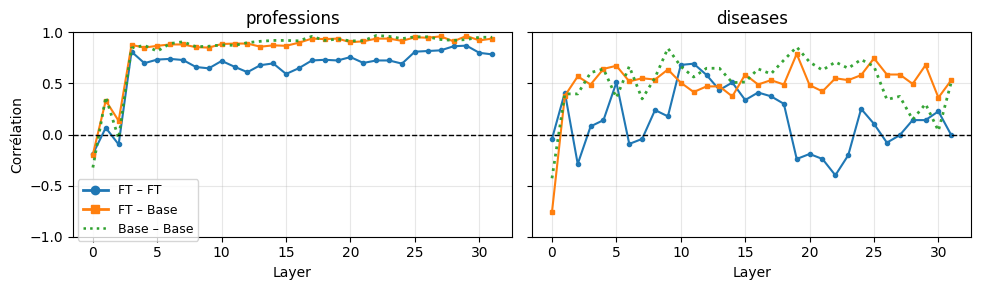

[INFO] Chargé 384 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/mistralai/Mistral-7B-Instruct-v0.1_lora_sft/spearman/correlation_summary_all_similarities.csv
[INFO] Chargé 384 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/mistralai/Mistral-7B-Instruct-v0.1_lora_sft/prev_pred/spearman/correlation_summary_all_similarities_prev_pred.csv
[INFO] Chargé 384 lignes depuis /home/bouchouchi/Gender_Bias/results/correlation/mistralai/Mistral-7B-Instruct-v0.1/spearman/correlation_summary_all_similarities.csv
[INFO] 64 lignes FT–FT, 64 lignes FT–Base, 64 lignes Base–Base
[SAVE] /home/bouchouchi/Gender_Bias/results/plots/correlation/mistralai_Mistral-7B-Instruct-v0.1_dot_vs_gen_dot_products_FTvsBase_2subplots.png


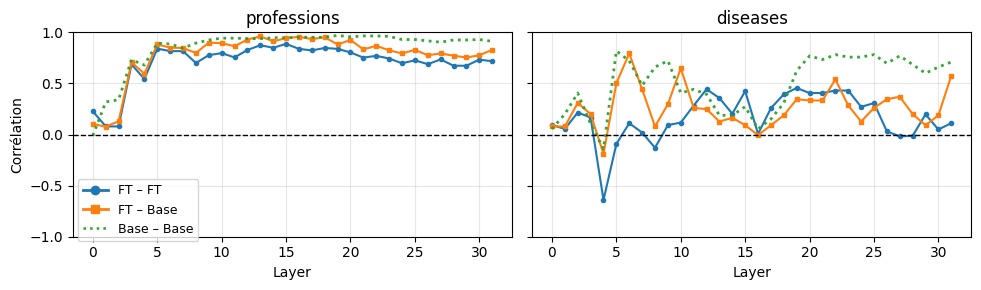

In [11]:
for model_name in model_names:
    for corr_kind in ["dot_vs_gen"]: #, "dot_vs_ppl"] :#["dot_vs_ppl", "dot_vs_gen", "dot_vs_logP"]:
        plot_3curves_from_csv(
            model_name,
            concepts=("professions", "diseases"),#("professions", "months", "colors", "sports",  "languages", "diseases"),
            target_method="FT",
            corr_kind=corr_kind,
            similarity_type="dot_products", 
            method="spearman", #spearman ou pearson
            use_lemma=False,
            ylim=(-1, 1), # None
            show=True
        )
